In [1]:
# All imports

from __future__ import print_function, division

import matplotlib.pyplot as plt
import numpy as np
import glob


import SimpleITK as sitk
import pandas as pd
import glob
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans

import csv
from scipy import ndimage, misc
from tqdm import tqdm

import numba
from numba import njit, prange

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')
import copy


import os
import glob
import uuid
import numpy as np


import numpy
import warnings

import functools
import pickle
import time


import numpy as np

import argparse
import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable

import torch.nn as nn

np.random.seed(0)
#torch.manual_seed(0)

In [41]:
# [STAR] Pytorch Models for training

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class SUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes
        self.bilinear   = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        
        self.dp1 = nn.Dropout(p=0.4)
        self.dp2 = nn.Dropout(p=0.4)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
        
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
        
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
            
        x = self.up3(x, x2)
        x = self.gn7(x)
        
        x  = self.up4(x, x1)
        
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class AttnDecoderRNN_old(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=256, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.bilinear = bilinear
        self.n_classes = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        self.lsgn_a = nn.GroupNorm(128,256)
    
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h = torch.unsqueeze(hidden,0)
        
        embedded = input
        
        embedded = self.dropout(embedded)

        hidden_bilstm = h[0]
        
        
        hidden_bilinn =  hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
    
        hidden_bilinn = self.lsgn_a(hidden_bilinn)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden_bilinn), 1)), dim=1)
        
        
        
        attn_weights  = self.lsgn_a(attn_weights)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
   #     print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
  #      print('The output shape is : ',output.shape)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
 #      print('The output shape after is : ',output.shape)
        
    
        hidden_bi = hidden_bilinn.unsqueeze(0)
        
        output = F.relu(output)
        
        #print("output and hidden before lstm ",output.shape,hidden_bi.shape)

        output, hidden = self.gru(output, hidden_bi)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        output = self.lsgn_a(output)
        
       #output = self.lsgn_a(output)
    
        return output,hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)

############### MAIN MODEL ##############
class UNetDoubleSmallGroupNormdifferent_old(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)

        
        self.down5 = Down(128,256)
        
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(128,256)
        
        self.lsgn2 = nn.GroupNorm(64,256)
        
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
   
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        #print('x5 shape is :',x5.shape)
        
        xlst = x5.reshape([4,256,256])

        lstm = nn.LSTM(256,256,batch_first= True,bidirectional=True,num_layers=1).cuda()
                
        #print('xlst',xlst.shape)    
        
        xlst = self.lsgn1(xlst)
        
        ylst = lstm(xlst)
        
        
        #print(hidden)
        
        f = np.asarray(ylst)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        
        
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,256,256))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
    
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,256,16,16])
        
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
 
        
        
        x5 = self.lsgn2(x5)
        
        ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)

        ups4 = ups4.cuda()
        
        opt = ups4(x5)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class UNetDoubleSmallGroupNormdifferent(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        super(UNetDoubleSmallGroupNormdifferent, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc     = DoubleConv(n_channels, 16)
        self.down1   = Down(16, 32)
        self.downnew = Down(16,16)
        self.down2   = Down(32, 64)
        self.down3   = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4   = Down(128, 256 // factor) 
        self.upsam   = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.down5 = Down(128,256)
        self.ups3  = nn.ConvTranspose2d(1 , 1, kernel_size=2, stride=2)
        self.ups4  = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.lsgn1 = nn.GroupNorm(64,128)
        
        self.lsgn2 = nn.GroupNorm(64,1024)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
        self.gn8 = nn.GroupNorm(4,8)
   
    def forward(self, x):
        #x = self.upsam()
        
        x1 = self.inc(x)
        x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        #x5 = self.down5(x5)
        #x5 = self.down6(x5)
        #print('x5:',x5.shape)
        
        xlst = x5.reshape([4,128,1024])
        

        lstm = nn.LSTM(1024,1024,batch_first= True,bidirectional=True,num_layers=1).cuda()
        
        xlst = self.lsgn1(xlst)
        ylst = lstm(xlst)
        
        f = np.asarray(ylst)
        
        h  = torch.cuda.FloatTensor(ylst[0])
        h = torch.squeeze(h)
        
        encoder_o = f[0]
        
        a = np.zeros((4,128,1024))
        #a = ndarray((4,128,1024))

        a = torch.from_numpy(a)
        a.cuda()
        
        for i in range(4):
            oo,b = attn_decoder1.forward(xlst,h[i],encoder_o[i])
            oo = self.lsgn2(oo)
            a[i] = oo
        
            
        a = a.unsqueeze(0)
        a = a.reshape([4,128,32,32])
        
        
        
        x5 = a  
        x5 = x5.cuda()
        
        
        x5 = x5.type(torch.cuda.FloatTensor)
        x5 = self.lsgn1(x5)
        
        #x5 = self.ups4(x5)
    
        x = self.up1(x5, x4)
        x = self.gn5(x)
        
        x = self.up2(x, x3)
        x = self.gn6(x)
       
        x = self.up3(x, x2)
        x = self.gn7(x)
       
        x = self.up4(x, x1)
        x = self.gn7(x)

        #x = self.downnew(x)
        
        #out    = self.out_softmax(logits)
        
        logits = self.outc(x)
        
        return logits

class UNetDoubleSmallWithoutGN(nn.Module):
    def __init__(self, n_channels, n_classes,bilinear=True):
        
        super(UNetDoubleSmallWithoutGN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc   = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.down5 = Down(128,256)
        
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
       # x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
       # x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
       # x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
       # x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        
        #x5 = torch.squeeze(x5)
        x5 = self.down5(x5)
        #x5 = self.down6(x5)
        
        ups4     = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        upsconv4 = DoubleConv(256,128)
        ups4 = ups4.cuda()
        
        opt = ups4(x5)
        
        x5 = opt
        
        x = self.up1(x5, x4)
        #x = self.gn5(x)
        
        x = self.up2(x, x3)
       # x = self.gn6(x)
       
        x = self.up3(x, x2)
        #x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=128, bilinear=True):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.bilinear = bilinear
        self.n_classes = 1

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(2048, 1024)
        
        self.attn2 = nn.Linear(1024,128)
        
        self.attn_24 = nn.Linear(self.hidden_size*4, self.hidden_size*2)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.attn_combine_bilstm = nn.Linear(3072, 1024)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(1024, 1024)
        self.out = nn.Linear(1024, 1024)
       # self.hidden = nn.Parameter(torch.randn(4,256,256).cuda()),nn.Parameter(torch.randn(4,256,256).cuda())
       
        self.lsgn_a = nn.GroupNorm(512,1024)
        
        self.lsgn_in = nn.GroupNorm(64,128)
    
        self.down5 = Down(128,256)
        
        factor = 2 if bilinear else 1
                
        self.ups4 = nn.ConvTranspose2d(256 , 256 // 2, kernel_size=2, stride=2)
        self.upsconv4 = DoubleConv(256,128)

        self.lstm = nn.LSTM(256,256,batch_first=False,bidirectional=True,num_layers=1).cuda()
    
    def forward(self, input,hidden,encoder_outputs):
        
        h = torch.unsqueeze(hidden,0)
        embedded = input
        embedded = self.dropout(embedded)
        embedded = self.lsgn_in(embedded)
        hidden_bilstm = h[0]
        hidden_bilinn =  hidden_bilstm
        
        hidden_bilinn = self.attn(hidden_bilinn)
        
        #print('hidden bilinn shape:',hidden_bilinn.shape)
    
        hidden_bilinn = self.lsgn_a(hidden_bilinn)
        #print(hidden_bilinn.shape)
        

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden_bilinn), 1)), dim=1)
        attn_weights  = self.lsgn_a(attn_weights)
        attn_weights  = self.attn2(attn_weights)
        attn_weights = self.lsgn_in(attn_weights)
        
        #print(attn_weights.unsqueeze(0).shape,encoder_outputs.unsqueeze(0).shape)
    
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        
        #print('attn_applied: encoder outputs',attn_applied[0].shape,encoder_outputs[0].shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        #print('The output shape is : ',output.shape)
        
        output = self.attn_combine_bilstm(output).unsqueeze(0)
        
        #print('The output shape after is : ',output.shape)
        
    
        hidden_bi = hidden_bilinn.unsqueeze(0)
        output    = F.relu(output)
        output    = self.lsgn_in(output)
        
        #print("output and hidden before lstm ",output.shape,hidden_bi.shape)

        output, hidden = self.gru(output, hidden_bi)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        output = self.lsgn_a(output)
        return output,hidden


    def initHidden(self):
        return torch.randn(4, 256, self.hidden_size, device=device)
#model = SUNet(1, 1)
#model.cuda()

In [ ]:
# [STAR] For training different models for comparison on MOSMEDDATA dataset

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/'
basepath_models  = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/models/single_models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy):
    loss_array = []
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return
device         = torch.device("cuda:0")


train_ids      = np.load(basepath+'TRAIN.npy')
val_ids        = np.load(basepath+'VALIDATION.npy')
test_ids       = np.load(basepath+'TEST.npy')
unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')
nocovid_ids    = np.load(basepath+'NOCOVID.npy')


unlabelled_ids     = unlabelled_ids
train_ids          = train_ids[:4]
val_ids            = val_ids
test_ids           = test_ids

trainx_l, trainy_l = read_training_data(train_ids)
valx, valy         = read_training_data(val_ids)
testx, testy       = read_training_data(test_ids)

print(trainx_l.shape, valx.shape, testx.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)
            
prev_max        = -1000
model_student   = SUNet(1, 1)
model_student.cuda()

optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0001)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())


val_dice_array   = []
train_dice_array = []
test_dice_array  = []

trainx, trainy   = sort_data(trainx_l, trainy_l)
total_epochs = 100


teacher_dice_array = []
for epoch in range(total_epochs):
    if epoch%10 ==1:
        print(epoch)

    train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy)
    
    val_dice      = evaluate_result(model_student, valx, valy)
    student_dice1 = evaluate_result(model_student, trainx, trainy)
    
    
    train_dice_array.append(np.mean(student_dice1))
    val_dice_array.append(np.mean(val_dice))
    
    model_save_name = "tmi-compare-sunet"
    
    if np.mean(val_dice) > prev_max:
        print("Step %d  Dice %.5f > %f  Train Dice %f " % (epoch, np.mean(val_dice), prev_max, np.mean(student_dice1)))
        prev_max     = np.mean(val_dice)
        torch.save(model_student.state_dict(), basepath_models+model_save_name+'-'+str(epoch)+".pt")

    #np.save(model_save_name+'_train.npy',      train_dice_array)
    #np.save(model_save_name+'_validation.npy', val_dice_array)

In [ ]:
# [STAR] For training different models for comparison on COVID-19 dataset using LSTM Model

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
import scipy
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/home/yu-hao/SEMISUNET/Dataset/'
basepath_models  = '/home/yu-hao/SEMISUNET/Dataset/models/'

def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 4
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 4
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def evaluate_result_new(pred, valy):
    val_dice       = []
    batch_size     = 4
    
    for ik in range(len(valx)//batch_size):
        output = pred[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y      = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]
        
        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            t1 = scipy.ndimage.zoom(output[0, 0].astype('uint8'), 0.6875, order=0)
            t2 = scipy.ndimage.zoom(y[0, 0].astype('uint8'),      0.6875, order=0)
            #print(t1.shape, t2.shape)
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    idx    = np.random.permutation(trainx.shape[0])
    trainx = trainx[idx]
    trainy = trainy[idx]
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def train_model1(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
        #x2 = model.forward(x)        
        #print(x2.shape)
        
#         lstm = nn.LSTM(512*512,512*512,batchfirst=True)
#         hidden = (torch.randn(1, 512, 512), torch.randn(1, 512, 512))
#         outlstm = lstm(x, hidden)
#         n = np.asarray(outlstm)
  
        print(i, x.shape[0])
        
        if(x.shape[0]!= 4):
            break
    
        x = np.expand_dims(x, 1)
        y = np.expand_dims(y, 1)
        y = torch.tensor(y, device=device).float()
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

def train_model2(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    #batch_size = 4
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
  
        if(x.shape[0]!=4):
            break
            
    
        x = np.expand_dims(x, 1)
        y = np.expand_dims(y, 1)

        y = torch.tensor(y, device=device).float()
        x = torch.tensor(x, device=device).float()
        
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

device         = torch.device("cuda:0")


# train_ids      = np.load(basepath+'TRAIN.npy')
# val_ids        = np.load(basepath+'VALIDATION.npy')
# test_ids       = np.load(basepath+'TEST.npy')
# unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')
# nocovid_ids    = np.load(basepath+'NOCOVID.npy')


# unlabelled_ids     = unlabelled_ids
# train_ids          = train_ids[:4]
# val_ids            = val_ids
# test_ids           = test_ids

trainx_l = np.load(basepath+'train_x.npy')/255.0
trainy_l = np.load(basepath+'train_y.npy')
trainy_l[trainy_l > 0] = 1

train_size    = 45
valx          = trainx_l[train_size:]
valy          = trainy_l[train_size:]

trainx_l = trainx_l[:train_size]
trainy_l = trainy_l[:train_size]

testx = np.load(basepath+'test_x.npy')/255.0
testy = np.load(basepath+'test_y.npy')
testy[testy > 0] = 1


trainx_l1 = np.zeros([trainx_l.shape[0], 1, 512, 512], dtype='float16')
valx1     = np.zeros([valx.shape[0], 1, 512, 512],     dtype='float16')
testx1    = np.zeros([testx.shape[0], 1, 512, 512],    dtype='float16')

trainy_l1 = np.zeros([trainy_l.shape[0], 1, 512, 512], dtype='float16')
valy1     = np.zeros([valy.shape[0], 1, 512, 512],     dtype='float16')
testy1    = np.zeros([testy.shape[0], 1, 512, 512],    dtype='float16')


for i in range(trainx_l.shape[0]):
    trainx_l1[i, 0] = scipy.ndimage.zoom(trainx_l[i], 2, order=3)
    trainy_l1[i, 0] = scipy.ndimage.zoom(trainy_l[i], 2, order=0)

for i in range(valx.shape[0]):
    valx1[i, 0] = scipy.ndimage.zoom(valx[i], 2, order=3)
    valy1[i, 0] = scipy.ndimage.zoom(valy[i], 2, order=0)

for i in range(testx.shape[0]):
    testx1[i, 0] = scipy.ndimage.zoom(testx[i], 2, order=3)
    testy1[i, 0] = scipy.ndimage.zoom(testy[i], 2, order=0)


trainx_l = trainx_l1
trainy_l = trainy_l1
valx     = valx1
valy     = valy1
testx    = testx1
testy    = testy1

print(trainx_l.shape, valx.shape, testx.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)

attn_decoder1 = AttnDecoderRNN(256, 256, dropout_p=0.45)
attn_decoder1.cuda()

prev_max        = -1000
model_student   = UNetDoubleSmallGroupNormdifferent(1, 1)
model_student.cuda()

optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0001)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())

optimizer_attn_w  = optim.Adam(attn_decoder1.parameters(), lr=0.0001, weight_decay=1e-5)


val_dice_array   = []
train_dice_array = []
test_dice_array  = []

trainx, trainy   = sort_data(trainx_l, trainy_l)
total_epochs = 1000


# trainx = np.expand_dims(trainx, axis=1)
# trainy = np.expand_dims(trainy, axis=1)

# valx   = np.expand_dims(valx, axis=1)
# valy   = np.expand_dims(valy, axis=1)

# testx  = np.expand_dims(testx, axis=1)
# testy  = np.expand_dims(testy, axis=1)

teacher_dice_array = []
test_dice_array    = []


for epoch in range(total_epochs):
    if epoch%10 ==1:
        print(epoch)
    #train_model1(model, optimizer, criterion, trainx, trainy, augment=False)
    train_loss    = train_model2(model_student, 4, optimizer_student, criterion, trainx, trainy, False)
    #train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, False)
    
    pred      = get_prediction(model_student, valx)
    val_dice1 = evaluate_result_new(pred, valy)
    #print(pred.shape, len(val_dice1), valy.shape)
    
    pred          = get_prediction(model_student, testx)
    student_dice2 = evaluate_result_new(pred, testy)
    #print(pred.shape, len(student_dice2), testy.shape)
    
    #val_dice      = evaluate_result(model_student, valx,   valy)
    student_dice1 = evaluate_result(model_student, trainx, trainy)
    #student_dice2 = evaluate_result(model_student, testx,  testy)
    
    
    train_dice_array.append(np.mean(student_dice1))
    val_dice_array.append(np.mean(val_dice1))
    test_dice_array.append(np.mean(student_dice2))

    model_save_name = "ipmi-attentionlstm-covid19"
    
    if np.mean(val_dice1) > prev_max:
        print("Step %d  Val Dice %.5f, Train Dice %f, Test Dice %f" % (epoch, np.mean(val_dice1), np.mean(student_dice1), np.mean(student_dice2)))
        prev_max     = np.mean(val_dice1)
        torch.save(model_student.state_dict(), basepath_models+model_save_name+'-6.pt')

(45, 1, 512, 512) (5, 1, 512, 512) (48, 1, 512, 512)
Step 0  Val Dice 0.38641, Train Dice 0.334668, Test Dice 0.337660
1
Step 2  Val Dice 0.39514, Train Dice 0.392259, Test Dice 0.425920
Step 3  Val Dice 0.46319, Train Dice 0.464655, Test Dice 0.502105
Step 4  Val Dice 0.58911, Train Dice 0.582315, Test Dice 0.616705
Step 5  Val Dice 0.61803, Train Dice 0.609297, Test Dice 0.643027
Step 6  Val Dice 0.66260, Train Dice 0.653285, Test Dice 0.672730
Step 7  Val Dice 0.66764, Train Dice 0.665725, Test Dice 0.681237
Step 9  Val Dice 0.69188, Train Dice 0.683809, Test Dice 0.694649
Step 10  Val Dice 0.69737, Train Dice 0.684531, Test Dice 0.699895
11
Step 12  Val Dice 0.71199, Train Dice 0.703339, Test Dice 0.710210
Step 13  Val Dice 0.71687, Train Dice 0.707096, Test Dice 0.723844
Step 14  Val Dice 0.71963, Train Dice 0.707066, Test Dice 0.723194
Step 16  Val Dice 0.72872, Train Dice 0.727326, Test Dice 0.742997
Step 17  Val Dice 0.73806, Train Dice 0.725543, Test Dice 0.730326
Step 20  Val

In [ ]:
#4,128,1024

In [19]:
# [STAR] For training different models for comparison on COVID-19 dataset using SU-Net Model

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
import scipy
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/home/yu-hao/SEMISUNET/Dataset/'
basepath_models  = '/home/yu-hao/SEMISUNET/Dataset/models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def evaluate_result_new(pred, valy):
    val_dice       = []
    batch_size     = 1
    
    for ik in range(len(valx)//batch_size):
        output = pred[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y      = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]
        
        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            t1 = scipy.ndimage.zoom(output[0, 0].astype('uint8'), 0.6875, order=0)
            t2 = scipy.ndimage.zoom(y[0, 0].astype('uint8'),      0.6875, order=0)
            #print(t1.shape, t2.shape)
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    idx    = np.random.permutation(trainx.shape[0])
    trainx = trainx[idx]
    trainy = trainy[idx]
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def train_model1(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
        #x2 = model.forward(x)        
        #print(x2.shape)
        
#         lstm = nn.LSTM(512*512,512*512,batchfirst=True)
#         hidden = (torch.randn(1, 512, 512), torch.randn(1, 512, 512))
#         outlstm = lstm(x, hidden)
#         n = np.asarray(outlstm)
  
        print(i, x.shape[0])
        
        if(x.shape[0]!= 4):
            break
    
        x = np.expand_dims(x, 1)
        y = np.expand_dims(y, 1)
        y = torch.tensor(y, device=device).float()
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

def train_model2(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    #batch_size = 4
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
  
        if(x.shape[0]!=4):
            break
            
    
        x = np.expand_dims(x, 1)
        

        y = np.expand_dims(y, 1)

        y = torch.tensor(y, device=device).float()
        
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

device         = torch.device("cuda:0")


# train_ids      = np.load(basepath+'TRAIN.npy')
# val_ids        = np.load(basepath+'VALIDATION.npy')
# test_ids       = np.load(basepath+'TEST.npy')
# unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')
# nocovid_ids    = np.load(basepath+'NOCOVID.npy')


# unlabelled_ids     = unlabelled_ids
# train_ids          = train_ids[:4]
# val_ids            = val_ids
# test_ids           = test_ids

trainx_l = np.load(basepath+'train_x.npy')/255.0
trainy_l = np.load(basepath+'train_y.npy')
trainy_l[trainy_l > 0] = 1

#index    = np.random.permutation(trainx_l.shape[0])
#trainx_l = trainx_l[index]
#trainy_l = trainy_l[index]

train_size    = 45
valx = trainx_l[train_size:]
valy = trainy_l[train_size:]

trainx_l = trainx_l[:train_size]
trainy_l = trainy_l[:train_size]

testx = np.load(basepath+'test_x.npy')/255.0
testy = np.load(basepath+'test_y.npy')
testy[testy > 0] = 1


trainx_l1 = np.zeros([trainx_l.shape[0], 1, 512, 512], dtype='float16')
valx1     = np.zeros([valx.shape[0], 1, 512, 512],     dtype='float16')
testx1    = np.zeros([testx.shape[0], 1, 512, 512],    dtype='float16')

trainy_l1 = np.zeros([trainy_l.shape[0], 1, 512, 512], dtype='float16')
valy1     = np.zeros([valy.shape[0], 1, 512, 512],     dtype='float16')
testy1    = np.zeros([testy.shape[0], 1, 512, 512],    dtype='float16')


for i in range(trainx_l.shape[0]):
    trainx_l1[i, 0] = scipy.ndimage.zoom(trainx_l[i], 2, order=3)
    trainy_l1[i, 0] = scipy.ndimage.zoom(trainy_l[i], 2, order=0)

for i in range(valx.shape[0]):
    valx1[i, 0] = scipy.ndimage.zoom(valx[i], 2, order=3)
    valy1[i, 0] = scipy.ndimage.zoom(valy[i], 2, order=0)

for i in range(testx.shape[0]):
    testx1[i, 0] = scipy.ndimage.zoom(testx[i], 2, order=3)
    testy1[i, 0] = scipy.ndimage.zoom(testy[i], 2, order=0)


trainx_l = trainx_l1
trainy_l = trainy_l1
valx = valx1
valy = valy1
testx = testx1
testy = testy1

print(trainx_l.shape, valx.shape, testx.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)

prev_max        = -1000
model_student   = SUNet(1, 1)
model_student.cuda()

optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0001)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())

val_dice_array   = []
train_dice_array = []
test_dice_array  = []

trainx, trainy   = trainx_l, trainy_l
trainx, trainy   = sort_data(trainx_l, trainy_l)
total_epochs = 30


# trainx = np.expand_dims(trainx, axis=1)
# trainy = np.expand_dims(trainy, axis=1)

# valx   = np.expand_dims(valx, axis=1)
# valy   = np.expand_dims(valy, axis=1)

# testx  = np.expand_dims(testx, axis=1)
# testy  = np.expand_dims(testy, axis=1)

teacher_dice_array = []
test_dice_array    = []


for epoch in range(total_epochs):
    if epoch%10 ==1:
        print(epoch)
    #train_model1(model, optimizer, criterion, trainx, trainy, augment=False)
    train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, False)
    #train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, False)
    
    pred      = get_prediction(model_student, valx)
    val_dice1 = evaluate_result_new(pred, valy)
    print(pred.shape, len(val_dice1), valy.shape)
    
    pred          = get_prediction(model_student, testx)
    student_dice2 = evaluate_result_new(pred, testy)
    print(pred.shape, len(student_dice2), testy.shape)
    
    #val_dice      = evaluate_result(model_student, valx,   valy)
    student_dice1 = evaluate_result(model_student, trainx, trainy)
    #student_dice2 = evaluate_result(model_student, testx,  testy)
    
    
    train_dice_array.append(np.mean(student_dice1))
    val_dice_array.append(np.mean(val_dice1))
    test_dice_array.append(np.mean(student_dice2))

    model_save_name = "ipmi-sunet-covid19"
    
    if np.mean(val_dice1) > prev_max:
        print("Step %d  Val Dice %.5f, Train Dice %f, Test Dice %f" % (epoch, np.mean(val_dice1), np.mean(student_dice1), np.mean(student_dice2)))
        prev_max     = np.mean(val_dice1)
        torch.save(model_student.state_dict(), basepath_models+model_save_name+'-6.pt')

    #np.save(model_save_name+'_train.npy',      train_dice_array)
    #np.save(model_save_name+'_validation.npy', val_dice_array)

(45, 1, 512, 512) (5, 1, 512, 512) (48, 1, 512, 512)
(5, 1, 512, 512) 5 (5, 1, 512, 512)
(48, 1, 512, 512) 5 (48, 1, 512, 512)
Step 0  Val Dice 0.40847, Train Dice 0.406240, Test Dice 0.550675
1
(5, 1, 512, 512) 5 (5, 1, 512, 512)
(48, 1, 512, 512) 5 (48, 1, 512, 512)
Step 1  Val Dice 0.52611, Train Dice 0.538528, Test Dice 0.641904
(5, 1, 512, 512) 5 (5, 1, 512, 512)
(48, 1, 512, 512) 5 (48, 1, 512, 512)
Step 2  Val Dice 0.61439, Train Dice 0.608030, Test Dice 0.689462
(5, 1, 512, 512) 5 (5, 1, 512, 512)
(48, 1, 512, 512) 5 (48, 1, 512, 512)
Step 3  Val Dice 0.69659, Train Dice 0.647938, Test Dice 0.715573
(5, 1, 512, 512) 5 (5, 1, 512, 512)
(48, 1, 512, 512) 5 (48, 1, 512, 512)
(5, 1, 512, 512) 5 (5, 1, 512, 512)
(48, 1, 512, 512) 5 (48, 1, 512, 512)
Step 5  Val Dice 0.70109, Train Dice 0.670300, Test Dice 0.733683
(5, 1, 512, 512) 5 (5, 1, 512, 512)
(48, 1, 512, 512) 5 (48, 1, 512, 512)
Step 6  Val Dice 0.71339, Train Dice 0.679548, Test Dice 0.740670
(5, 1, 512, 512) 5 (5, 1, 512, 

In [ ]:
get_predictions

In [ ]:
# 2 GN
# (45, 1, 512, 512) (5, 1, 512, 512) (48, 1, 512, 512)
# Step 0  Val Dice 0.00000, Train Dice 0.000000, Test Dice 0.000000
# 1
# Step 6  Val Dice 0.05016, Train Dice 0.118959, Test Dice 0.103342
# Step 7  Val Dice 0.31815, Train Dice 0.349599, Test Dice 0.307122
# Step 8  Val Dice 0.63631, Train Dice 0.543914, Test Dice 0.578809
# Step 9  Val Dice 0.68335, Train Dice 0.621097, Test Dice 0.635156
# Step 10  Val Dice 0.69556, Train Dice 0.637887, Test Dice 0.651901
# 11
# Step 13  Val Dice 0.70388, Train Dice 0.646838, Test Dice 0.665426
# Step 14  Val Dice 0.70715, Train Dice 0.654906, Test Dice 0.670942
# Step 20  Val Dice 0.71351, Train Dice 0.662403, Test Dice 0.674490
# 21
# Step 21  Val Dice 0.71357, Train Dice 0.668946, Test Dice 0.669391
# Step 24  Val Dice 0.72196, Train Dice 0.666852, Test Dice 0.682729
# Step 27  Val Dice 0.72361, Train Dice 0.687283, Test Dice 0.683081
# Step 30  Val Dice 0.73600, Train Dice 0.696675, Test Dice 0.692754
# 31
# Step 36  Val Dice 0.73605, Train Dice 0.702647, Test Dice 0.666775
# Step 37  Val Dice 0.75148, Train Dice 0.710645, Test Dice 0.671546
# 41
# Step 44  Val Dice 0.75176, Train Dice 0.713824, Test Dice 0.652402
# Step 45  Val Dice 0.76012, Train Dice 0.744207, Test Dice 0.689487
# Step 46  Val Dice 0.77758, Train Dice 0.743573, Test Dice 0.683576
# 51
# 61
# Step 61  Val Dice 0.77897, Train Dice 0.743691, Test Dice 0.692439
# Step 65  Val Dice 0.77912, Train Dice 0.763989, Test Dice 0.692671
# Step 66  Val Dice 0.77998, Train Dice 0.783560, Test Dice 0.706940
# 71
# 81
# Step 81  Val Dice 0.78727, Train Dice 0.797163, Test Dice 0.701257

# 4 GN
# (45, 1, 512, 512) (5, 1, 512, 512) (48, 1, 512, 512)
# Step 0  Val Dice 0.00000, Train Dice 0.000000, Test Dice 0.000001
# 1
# Step 4  Val Dice 0.11335, Train Dice 0.059222, Test Dice 0.060365
# Step 5  Val Dice 0.52040, Train Dice 0.461123, Test Dice 0.436235
# Step 6  Val Dice 0.68600, Train Dice 0.626483, Test Dice 0.622587
# Step 9  Val Dice 0.70716, Train Dice 0.667402, Test Dice 0.657514
# Step 10  Val Dice 0.72560, Train Dice 0.686944, Test Dice 0.671868
# 11
# Step 13  Val Dice 0.73194, Train Dice 0.692215, Test Dice 0.660874
# Step 14  Val Dice 0.74235, Train Dice 0.701571, Test Dice 0.671201
# Step 16  Val Dice 0.74756, Train Dice 0.704440, Test Dice 0.683192
# Step 19  Val Dice 0.75899, Train Dice 0.710249, Test Dice 0.669616
# Step 20  Val Dice 0.76912, Train Dice 0.744263, Test Dice 0.689958
# 21
# Step 28  Val Dice 0.77397, Train Dice 0.765428, Test Dice 0.692351
# 31
# Step 33  Val Dice 0.77443, Train Dice 0.785372, Test Dice 0.709192
# Step 38  Val Dice 0.78444, Train Dice 0.792295, Test Dice 0.686179
# 41
# Step 41  Val Dice 0.78921, Train Dice 0.781758, Test Dice 0.687306
# 51
# 61
# 71
# 81
# 91
# 101
# 111
# 121
# 131
# 141

In [5]:
# Sort
# (40, 1, 512, 512) (10, 1, 512, 512) (48, 1, 512, 512)
# Step 0  Val Dice 0.00027, Train Dice 0.001213, Test Dice 0.001755
# 1
# Step 7  Val Dice 0.00382, Train Dice 0.076572, Test Dice 0.054568
# Step 8  Val Dice 0.31308, Train Dice 0.248025, Test Dice 0.250341
# Step 9  Val Dice 0.60493, Train Dice 0.452303, Test Dice 0.445337
# Step 10  Val Dice 0.70992, Train Dice 0.664974, Test Dice 0.652485
# 11
# Step 11  Val Dice 0.73933, Train Dice 0.652466, Test Dice 0.646877
# Step 12  Val Dice 0.74122, Train Dice 0.713898, Test Dice 0.702860
# Step 13  Val Dice 0.76766, Train Dice 0.722366, Test Dice 0.689882
# Step 19  Val Dice 0.77753, Train Dice 0.765109, Test Dice 0.718724
# 21
# Step 21  Val Dice 0.78552, Train Dice 0.778215, Test Dice 0.698430
# Step 22  Val Dice 0.78576, Train Dice 0.762371, Test Dice 0.676977
# Step 27  Val Dice 0.79172, Train Dice 0.801648, Test Dice 0.696595

# Non sort
# (40, 1, 512, 512) (10, 1, 512, 512) (48, 1, 512, 512)
# Step 0  Val Dice 0.47310, Train Dice 0.414437, Test Dice 0.457420
# 1
# Step 1  Val Dice 0.62207, Train Dice 0.525722, Test Dice 0.565086
# Step 2  Val Dice 0.62731, Train Dice 0.539318, Test Dice 0.562520
# Step 3  Val Dice 0.66079, Train Dice 0.576287, Test Dice 0.590151
# Step 5  Val Dice 0.66563, Train Dice 0.573630, Test Dice 0.571538
# Step 6  Val Dice 0.69991, Train Dice 0.634576, Test Dice 0.628347
# Step 7  Val Dice 0.72765, Train Dice 0.634495, Test Dice 0.625526
# Step 8  Val Dice 0.74690, Train Dice 0.681710, Test Dice 0.675751
# 11
# Step 11  Val Dice 0.76492, Train Dice 0.708205, Test Dice 0.687793
# Step 14  Val Dice 0.77187, Train Dice 0.736016, Test Dice 0.693092
# Step 16  Val Dice 0.78225, Train Dice 0.737534, Test Dice 0.680775
# 21
# Step 23  Val Dice 0.79977, Train Dice 0.783781, Test Dice 0.695209

(1600, 256, 256)


In [134]:
# [STAR] Semi-supervised training SU-Net Model

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
import scipy
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/'
basepath_models  = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, datax):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(datax)//batch_size):
        x = datax[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    idx    = np.random.permutation(trainx.shape[0])
    trainx = trainx[idx]
    trainy = trainy[idx]
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def train_model1(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
        #x2 = model.forward(x)        
        #print(x2.shape)
        
#         lstm = nn.LSTM(512*512,512*512,batchfirst=True)
#         hidden = (torch.randn(1, 512, 512), torch.randn(1, 512, 512))
#         outlstm = lstm(x, hidden)
#         n = np.asarray(outlstm)
  
        print(i, x.shape[0])
        
        if(x.shape[0]!= 4):
            break
    
        x = np.expand_dims(x, 1)
        y = np.expand_dims(y, 1)
        y = torch.tensor(y, device=device).float()
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

def train_model2(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    #batch_size = 4
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
  
        if(x.shape[0]!=4):
            break
            
    
        x = np.expand_dims(x, 1)
        

        y = np.expand_dims(y, 1)

        y = torch.tensor(y, device=device).float()
        
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

device         = torch.device("cuda:0")


# train_ids      = np.load(basepath+'TRAIN.npy')
# val_ids        = np.load(basepath+'VALIDATION.npy')
# test_ids       = np.load(basepath+'TEST.npy')
# unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')
# nocovid_ids    = np.load(basepath+'NOCOVID.npy')


# unlabelled_ids     = unlabelled_ids
# train_ids          = train_ids[:4]
# val_ids            = val_ids
# test_ids           = test_ids

trainx_l = np.load(basepath+'train_x.npy')/255.0
trainy_l = np.load(basepath+'train_y.npy')
trainy_l[trainy_l > 0] = 1

train_size    = 45
valx = trainx_l[train_size:]
valy = trainy_l[train_size:]

trainx_l = trainx_l[:train_size]
trainy_l = trainy_l[:train_size]

testx = np.load(basepath+'test_x.npy')/255.0
testy = np.load(basepath+'test_y.npy')
testy[testy > 0] = 1

unlabelledx_l = np.load(basepath+'unlabelled_x.npy')/255.0


trainx_l1 = np.zeros([trainx_l.shape[0], 1, 512, 512], dtype='float16')
valx1     = np.zeros([valx.shape[0], 1, 512, 512],     dtype='float16')
testx1    = np.zeros([testx.shape[0], 1, 512, 512],    dtype='float16')
unlabelledx1    = np.zeros([unlabelledx_l.shape[0], 1, 512, 512],    dtype='float16')

trainy_l1 = np.zeros([trainy_l.shape[0], 1, 512, 512], dtype='float16')
valy1     = np.zeros([valy.shape[0], 1, 512, 512],     dtype='float16')
testy1    = np.zeros([testy.shape[0], 1, 512, 512],    dtype='float16')

for i in range(trainx_l.shape[0]):
    trainx_l1[i, 0] = scipy.ndimage.zoom(trainx_l[i], 2, order=3)
    trainy_l1[i, 0] = scipy.ndimage.zoom(trainy_l[i], 2, order=0)

for i in range(valx.shape[0]):
    valx1[i, 0] = scipy.ndimage.zoom(valx[i], 2, order=3)
    valy1[i, 0] = scipy.ndimage.zoom(valy[i], 2, order=0)

for i in range(testx.shape[0]):
    testx1[i, 0] = scipy.ndimage.zoom(testx[i], 2, order=3)
    testy1[i, 0] = scipy.ndimage.zoom(testy[i], 2, order=0)

for i in range(unlabelledx1.shape[0]):
    unlabelledx1[i, 0] = scipy.ndimage.zoom(unlabelledx_l[i], 2, order=3)
    #testy1[i, 0] = scipy.ndimage.zoom(unlabelledy1[i], 2, order=0)

model_student   = SUNet(1, 1)
model_student.cuda()
p1         = torch.load(basepath_models+"tmi-compare-sunet-covid19-30.pt")
model_student.load_state_dict(p1)


unlabelledy1 = get_prediction(model_student, unlabelledx1)

trainx_l = trainx_l1
trainy_l = trainy_l1
valx = valx1
valy = valy1
testx = testx1
testy = testy1

print(trainx_l.shape, valx.shape, testx.shape, unlabelledy1.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)

prev_max        = -1000
model_student   = SUNet(1, 1)
model_student.cuda()
p1         = torch.load(basepath_models+"tmi-compare-sunet-covid19-30.pt")
model_student.load_state_dict(p1)

optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0001)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())
#criterion          = nn.MSELoss()

val_dice_array   = []
train_dice_array = []
test_dice_array  = []

#trainy[trainy > 0.5] = 1
#trainy[trainy < 0.5] = 0
total_epochs     = 1000
#trainx, trainy   = sort_data(trainx, trainy)

trainx = trainx#[800:]
trainy = trainy#[800:]
# trainx = np.expand_dims(trainx, axis=1)
# trainy = np.expand_dims(trainy, axis=1)

# valx   = np.expand_dims(valx, axis=1)
# valy   = np.expand_dims(valy, axis=1)

# testx  = np.expand_dims(testx, axis=1)
# testy  = np.expand_dims(testy, axis=1)

teacher_dice_array = []
test_dice_array    = []

index        = np.random.permutation(np.arange(len(unlabelledx1)))
unlabelledx1 = unlabelledx1[index]
unlabelledy1 = unlabelledy1[index]

for epoch in range(total_epochs):
    if epoch%10 ==1:
        print(epoch)
    
    # Re-generate pseudo labels again
    if epoch%5 == 0:
        step_size        = len(unlabelledx1)//20-1
        inputx           = unlabelledx1#[0:(1+epoch%20)*step_size]
        unlabelledy1     = get_prediction(model_student, inputx)
        #unlabelledy1[unlabelledy1 < 0.5] = 0
        #unlabelledy1[unlabelledy1 > 0.5] = 1
        trainx_l1        = inputx#np.concatenate([trainx_l, inputx], axis=0)
        trainy_l1        = unlabelledy1#np.concatenate([trainy_l, unlabelledy1], axis=0)
        trainx, trainy   = sort_data(trainx_l1, trainy_l1)
    
    #train_model1(model, optimizer, criterion, trainx, trainy, augment=False)
    train_loss    = train_model(model_student, 4, optimizer_student, criterion, trainx, trainy, False)
    #train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, False)
    
    val_dice      = evaluate_result(model_student, valx,   valy)
    student_dice1 = evaluate_result(model_student, trainx, trainy)
    student_dice2 = evaluate_result(model_student, testx,  testy)
    
    
    train_dice_array.append(np.mean(student_dice1))
    val_dice_array.append(np.mean(val_dice))
    test_dice_array.append(np.mean(student_dice2))
    
    
    model_save_name = "tmi-compare-sunet-covid19-semi"
    
    #if np.mean(val_dice) > prev_max:
    print("Step %d  Val Dice %.5f, Train Dice %f, Test Dice %f" % (epoch, np.mean(val_dice), np.mean(student_dice1), np.mean(student_dice2)))
    prev_max     = np.mean(val_dice)
    torch.save(model_student.state_dict(), basepath_models+model_save_name+'-'+str(epoch)+".pt")

    #np.save(model_save_name+'_train.npy',      train_dice_array)
    #np.save(model_save_name+'_validation.npy', val_dice_array)

(45, 1, 512, 512) (5, 1, 512, 512) (48, 1, 512, 512) (1600, 1, 512, 512)
Step 0  Val Dice 0.77634, Train Dice 0.153924, Test Dice 0.723316
1
Step 1  Val Dice 0.76877, Train Dice 0.116518, Test Dice 0.705424
Step 2  Val Dice 0.73067, Train Dice 0.094445, Test Dice 0.683303
Step 3  Val Dice 0.77280, Train Dice 0.142163, Test Dice 0.717842
Step 4  Val Dice 0.77123, Train Dice 0.139559, Test Dice 0.715836
Step 5  Val Dice 0.77141, Train Dice 0.139238, Test Dice 0.715969
Step 6  Val Dice 0.77118, Train Dice 0.139625, Test Dice 0.715823
Step 7  Val Dice 0.77121, Train Dice 0.136001, Test Dice 0.715501
Step 8  Val Dice 0.77273, Train Dice 0.143900, Test Dice 0.715735
Step 9  Val Dice 0.77085, Train Dice 0.139977, Test Dice 0.715868
Step 10  Val Dice 0.77275, Train Dice 0.135950, Test Dice 0.714477
11
Step 11  Val Dice 0.77103, Train Dice 0.145491, Test Dice 0.716586
Step 12  Val Dice 0.77145, Train Dice 0.137945, Test Dice 0.714228
Step 13  Val Dice 0.77043, Train Dice 0.137131, Test Dice 0.7

KeyboardInterrupt: 

In [97]:
print(inputx.shape, unlabelledy1.shape)

(319, 1, 512, 512) (316, 1, 512, 512)


In [ ]:
# Iterative Without threshdoling

# Non-Iterative Without threshdoling

In [ ]:
# Without Thresholding SU-Net covid-19

# All
# (40, 1, 512, 512) (10, 1, 512, 512) (48, 1, 512, 512) (1600, 1, 512, 512)
# Step 0  Val Dice 0.76960, Train Dice 0.086486, Test Dice 0.695945
# 1
# Step 1  Val Dice 0.76680, Train Dice 0.088690, Test Dice 0.678503
# Step 2  Val Dice 0.75676, Train Dice 0.090160, Test Dice 0.709546
# Step 3  Val Dice 0.76640, Train Dice 0.085630, Test Dice 0.672755
# Step 4  Val Dice 0.75804, Train Dice 0.096443, Test Dice 0.722479
# Step 5  Val Dice 0.76218, Train Dice 0.092003, Test Dice 0.719346
# Step 6  Val Dice 0.78326, Train Dice 0.089921, Test Dice 0.710196
# Step 7  Val Dice 0.74530, Train Dice 0.100489, Test Dice 0.725772
# Step 8  Val Dice 0.76933, Train Dice 0.096645, Test Dice 0.724160
# Step 9  Val Dice 0.77539, Train Dice 0.081607, Test Dice 0.671963
# Step 10  Val Dice 0.78023, Train Dice 0.089463, Test Dice 0.706236
# 11
# Step 11  Val Dice 0.78315, Train Dice 0.086977, Test Dice 0.705594
# Step 12  Val Dice 0.78709, Train Dice 0.093157, Test Dice 0.710461
# Step 13  Val Dice 0.69627, Train Dice 0.062377, Test Dice 0.568129
# Step 14  Val Dice 0.77469, Train Dice 0.096401, Test Dice 0.727789
# Step 15  Val Dice 0.77551, Train Dice 0.092316, Test Dice 0.700556
# Step 16  Val Dice 0.77993, Train Dice 0.085810, Test Dice 0.697788
# Step 17  Val Dice 0.78453, Train Dice 0.094763, Test Dice 0.720082
# Step 18  Val Dice 0.79124, Train Dice 0.092550, Test Dice 0.709006
# Step 19  Val Dice 0.78343, Train Dice 0.091609, Test Dice 0.709662
# Step 20  Val Dice 0.78500, Train Dice 0.093218, Test Dice 0.714936
# 21
# Step 21  Val Dice 0.77866, Train Dice 0.089802, Test Dice 0.697119
# Step 22  Val Dice 0.77554, Train Dice 0.096152, Test Dice 0.716012
# Step 23  Val Dice 0.78234, Train Dice 0.092014, Test Dice 0.712717
# Step 24  Val Dice 0.78059, Train Dice 0.095741, Test Dice 0.716026
# Step 25  Val Dice 0.78056, Train Dice 0.096267, Test Dice 0.716681
# Step 26  Val Dice 0.77195, Train Dice 0.087644, Test Dice 0.690997
# Step 27  Val Dice 0.77858, Train Dice 0.098494, Test Dice 0.723717
# Step 28  Val Dice 0.78784, Train Dice 0.091096, Test Dice 0.705478
# Step 29  Val Dice 0.78401, Train Dice 0.093413, Test Dice 0.702934
# Step 30  Val Dice 0.77420, Train Dice 0.087512, Test Dice 0.673745
# 31
# Step 31  Val Dice 0.78071, Train Dice 0.091674, Test Dice 0.709491
# Step 32  Val Dice 0.78643, Train Dice 0.088662, Test Dice 0.701180
# Step 33  Val Dice 0.78092, Train Dice 0.090681, Test Dice 0.687806
# Step 34  Val Dice 0.78879, Train Dice 0.093551, Test Dice 0.709777
# Step 35  Val Dice 0.78320, Train Dice 0.095863, Test Dice 0.711491
# Step 36  Val Dice 0.78647, Train Dice 0.092875, Test Dice 0.707001
# Step 37  Val Dice 0.78129, Train Dice 0.094385, Test Dice 0.710185
# Step 38  Val Dice 0.78459, Train Dice 0.091607, Test Dice 0.699432
# Step 39  Val Dice 0.76512, Train Dice 0.099071, Test Dice 0.720157
# Step 40  Val Dice 0.78041, Train Dice 0.095752, Test Dice 0.708487
# 41
# Step 41  Val Dice 0.77891, Train Dice 0.096113, Test Dice 0.708067
# Step 42  Val Dice 0.78342, Train Dice 0.096345, Test Dice 0.714913
# Step 43  Val Dice 0.77716, Train Dice 0.096061, Test Dice 0.713501
# Step 44  Val Dice 0.77556, Train Dice 0.095669, Test Dice 0.715358
# Step 45  Val Dice 0.78359, Train Dice 0.094337, Test Dice 0.697413
# Step 46  Val Dice 0.78133, Train Dice 0.094720, Test Dice 0.702655
# Step 47  Val Dice 0.77036, Train Dice 0.096502, Test Dice 0.711313
# Step 48  Val Dice 0.78490, Train Dice 0.094728, Test Dice 0.693549
# Step 49  Val Dice 0.78311, Train Dice 0.095501, Test Dice 0.697564
# Step 50  Val Dice 0.78698, Train Dice 0.094604, Test Dice 0.696109
# 51
# Step 51  Val Dice 0.76679, Train Dice 0.089120, Test Dice 0.700028
# Step 52  Val Dice 0.77652, Train Dice 0.093872, Test Dice 0.704631
# Step 53  Val Dice 0.78068, Train Dice 0.094548, Test Dice 0.700081
# Step 54  Val Dice 0.77043, Train Dice 0.096046, Test Dice 0.698489
# Step 55  Val Dice 0.78204, Train Dice 0.095159, Test Dice 0.707760
# Step 56  Val Dice 0.77453, Train Dice 0.096047, Test Dice 0.705782
# Step 57  Val Dice 0.79178, Train Dice 0.093507, Test Dice 0.703230
# Step 58  Val Dice 0.77803, Train Dice 0.096408, Test Dice 0.699404
# Step 59  Val Dice 0.78115, Train Dice 0.094943, Test Dice 0.703442
# Step 60  Val Dice 0.78245, Train Dice 0.093809, Test Dice 0.687335
# 61
# Step 61  Val Dice 0.77171, Train Dice 0.094787, Test Dice 0.698197
# Step 62  Val Dice 0.77956, Train Dice 0.095218, Test Dice 0.701594
# Step 63  Val Dice 0.78030, Train Dice 0.097245, Test Dice 0.698260

# 200
# (40, 1, 512, 512) (10, 1, 512, 512) (48, 1, 512, 512) (1600, 1, 512, 512)
# Step 0  Val Dice 0.74634, Train Dice 0.096919, Test Dice 0.692648
# 1
# Step 1  Val Dice 0.75567, Train Dice 0.113393, Test Dice 0.714680
# Step 2  Val Dice 0.76548, Train Dice 0.085316, Test Dice 0.660143
# Step 3  Val Dice 0.78061, Train Dice 0.094858, Test Dice 0.687344
# Step 4  Val Dice 0.77420, Train Dice 0.109518, Test Dice 0.722472
# Step 5  Val Dice 0.76873, Train Dice 0.106067, Test Dice 0.678752
# Step 6  Val Dice 0.77391, Train Dice 0.109509, Test Dice 0.717850
# Step 7  Val Dice 0.78515, Train Dice 0.098746, Test Dice 0.702177
# Step 8  Val Dice 0.79146, Train Dice 0.102465, Test Dice 0.716334
# Step 9  Val Dice 0.78303, Train Dice 0.102859, Test Dice 0.710842
# Step 10  Val Dice 0.79075, Train Dice 0.097922, Test Dice 0.701302
# 11
# Step 11  Val Dice 0.78602, Train Dice 0.105189, Test Dice 0.715962
# Step 12  Val Dice 0.78620, Train Dice 0.103557, Test Dice 0.713915
# Step 13  Val Dice 0.78869, Train Dice 0.099656, Test Dice 0.708253
# Step 14  Val Dice 0.78398, Train Dice 0.105993, Test Dice 0.717645
# Step 15  Val Dice 0.78865, Train Dice 0.100477, Test Dice 0.713139
# Step 16  Val Dice 0.78464, Train Dice 0.102017, Test Dice 0.711767
# Step 17  Val Dice 0.77246, Train Dice 0.094232, Test Dice 0.672174
# Step 18  Val Dice 0.78583, Train Dice 0.098426, Test Dice 0.697059
# Step 19  Val Dice 0.76829, Train Dice 0.092097, Test Dice 0.701564
# Step 20  Val Dice 0.78649, Train Dice 0.101227, Test Dice 0.710348
# 21
# Step 21  Val Dice 0.78889, Train Dice 0.101472, Test Dice 0.705186
# Step 22  Val Dice 0.78545, Train Dice 0.106239, Test Dice 0.715938
# Step 23  Val Dice 0.78612, Train Dice 0.103149, Test Dice 0.716769
# Step 24  Val Dice 0.78571, Train Dice 0.100187, Test Dice 0.701511
# Step 25  Val Dice 0.79013, Train Dice 0.101526, Test Dice 0.716037
# Step 26  Val Dice 0.78934, Train Dice 0.104168, Test Dice 0.717593
# Step 27  Val Dice 0.78702, Train Dice 0.105027, Test Dice 0.702148
# Step 28  Val Dice 0.75876, Train Dice 0.112148, Test Dice 0.731801
# Step 29  Val Dice 0.77488, Train Dice 0.107388, Test Dice 0.714125
# Step 30  Val Dice 0.78428, Train Dice 0.100493, Test Dice 0.696862
# 31
# Step 31  Val Dice 0.78336, Train Dice 0.104836, Test Dice 0.707322
# Step 32  Val Dice 0.78407, Train Dice 0.103721, Test Dice 0.709621
# Step 33  Val Dice 0.78611, Train Dice 0.104923, Test Dice 0.713980
# Step 34  Val Dice 0.78941, Train Dice 0.105856, Test Dice 0.718466
# Step 35  Val Dice 0.78648, Train Dice 0.102528, Test Dice 0.711470
# Step 36  Val Dice 0.79251, Train Dice 0.104248, Test Dice 0.709666
# Step 37  Val Dice 0.79069, Train Dice 0.106425, Test Dice 0.715234
# Step 38  Val Dice 0.78394, Train Dice 0.101496, Test Dice 0.700881
# Step 39  Val Dice 0.77843, Train Dice 0.105345, Test Dice 0.715907

#400
# (40, 1, 512, 512) (10, 1, 512, 512) (48, 1, 512, 512) (1600, 1, 512, 512)
# Step 0  Val Dice 0.75230, Train Dice 0.101206, Test Dice 0.650249
# 1
# Step 1  Val Dice 0.76599, Train Dice 0.106628, Test Dice 0.693211
# Step 2  Val Dice 0.77040, Train Dice 0.103857, Test Dice 0.671344
# Step 3  Val Dice 0.77045, Train Dice 0.122281, Test Dice 0.718886
# Step 4  Val Dice 0.78309, Train Dice 0.105207, Test Dice 0.681917
# Step 5  Val Dice 0.77282, Train Dice 0.116804, Test Dice 0.699086
# Step 6  Val Dice 0.78173, Train Dice 0.117289, Test Dice 0.704573
# Step 7  Val Dice 0.77906, Train Dice 0.106698, Test Dice 0.700022
# Step 8  Val Dice 0.76877, Train Dice 0.122936, Test Dice 0.720944
# Step 9  Val Dice 0.76531, Train Dice 0.108972, Test Dice 0.695032
# Step 10  Val Dice 0.76762, Train Dice 0.109099, Test Dice 0.702491
# 11
# Step 11  Val Dice 0.78665, Train Dice 0.117951, Test Dice 0.714834
# Step 12  Val Dice 0.76575, Train Dice 0.098176, Test Dice 0.654575
# Step 13  Val Dice 0.77748, Train Dice 0.112553, Test Dice 0.695828
# Step 14  Val Dice 0.78206, Train Dice 0.119942, Test Dice 0.718196
# Step 15  Val Dice 0.77613, Train Dice 0.119922, Test Dice 0.711672
# Step 16  Val Dice 0.78377, Train Dice 0.124576, Test Dice 0.727247
# Step 17  Val Dice 0.79024, Train Dice 0.111336, Test Dice 0.700918
# Step 18  Val Dice 0.78263, Train Dice 0.118029, Test Dice 0.710809
# Step 19  Val Dice 0.77670, Train Dice 0.120491, Test Dice 0.717174
# Step 20  Val Dice 0.78638, Train Dice 0.112238, Test Dice 0.696694
# 21
# Step 21  Val Dice 0.78196, Train Dice 0.120038, Test Dice 0.719291
# Step 22  Val Dice 0.78028, Train Dice 0.115958, Test Dice 0.716562
# Step 23  Val Dice 0.78073, Train Dice 0.120539, Test Dice 0.700957
# Step 24  Val Dice 0.79044, Train Dice 0.108482, Test Dice 0.696392
# Step 25  Val Dice 0.79283, Train Dice 0.113291, Test Dice 0.703540

#800
# (40, 1, 512, 512) (10, 1, 512, 512) (48, 1, 512, 512) (1600, 1, 512, 512)
# Step 0  Val Dice 0.73472, Train Dice 0.158629, Test Dice 0.682844
# 1
# Step 1  Val Dice 0.77439, Train Dice 0.158773, Test Dice 0.696564
# Step 2  Val Dice 0.77997, Train Dice 0.140926, Test Dice 0.671849
# Step 3  Val Dice 0.78561, Train Dice 0.148026, Test Dice 0.691112
# Step 4  Val Dice 0.75413, Train Dice 0.150734, Test Dice 0.694628
# Step 5  Val Dice 0.78264, Train Dice 0.155732, Test Dice 0.690054
# Step 6  Val Dice 0.78519, Train Dice 0.150693, Test Dice 0.697227
# Step 7  Val Dice 0.77686, Train Dice 0.153245, Test Dice 0.695094
# Step 8  Val Dice 0.78195, Train Dice 0.150747, Test Dice 0.687839
# Step 9  Val Dice 0.78251, Train Dice 0.144772, Test Dice 0.685603
# Step 10  Val Dice 0.77868, Train Dice 0.160324, Test Dice 0.706527
# 11
# Step 11  Val Dice 0.78995, Train Dice 0.158198, Test Dice 0.714903
# Step 12  Val Dice 0.78065, Train Dice 0.155356, Test Dice 0.704081
# Step 13  Val Dice 0.78358, Train Dice 0.154340, Test Dice 0.696042
# Step 14  Val Dice 0.76411, Train Dice 0.161165, Test Dice 0.715797
# Step 15  Val Dice 0.78057, Train Dice 0.139103, Test Dice 0.679545
# Step 16  Val Dice 0.76315, Train Dice 0.128445, Test Dice 0.647859
# Step 17  Val Dice 0.78328, Train Dice 0.156562, Test Dice 0.705554
# Step 18  Val Dice 0.78794, Train Dice 0.152850, Test Dice 0.695145
# Step 19  Val Dice 0.77639, Train Dice 0.155153, Test Dice 0.706256
# Step 20  Val Dice 0.78459, Train Dice 0.154809, Test Dice 0.688036
# 21
# Step 21  Val Dice 0.78294, Train Dice 0.160343, Test Dice 0.702798
# Step 22  Val Dice 0.78745, Train Dice 0.159909, Test Dice 0.703682
# Step 23  Val Dice 0.77172, Train Dice 0.160035, Test Dice 0.709891
# Step 24  Val Dice 0.78460, Train Dice 0.161159, Test Dice 0.704819
# Step 25  Val Dice 0.77785, Train Dice 0.162993, Test Dice 0.703123
# Step 26  Val Dice 0.77868, Train Dice 0.158767, Test Dice 0.701666
# Step 27  Val Dice 0.78560, Train Dice 0.158326, Test Dice 0.701601
# Step 28  Val Dice 0.78494, Train Dice 0.160455, Test Dice 0.700043
# Step 29  Val Dice 0.77863, Train Dice 0.161924, Test Dice 0.704310
# Step 30  Val Dice 0.77325, Train Dice 0.155435, Test Dice 0.711685
# 31
# Step 31  Val Dice 0.78218, Train Dice 0.158349, Test Dice 0.700234
# Step 32  Val Dice 0.78080, Train Dice 0.160715, Test Dice 0.703748
# Step 33  Val Dice 0.75618, Train Dice 0.169156, Test Dice 0.709846
# Step 34  Val Dice 0.78608, Train Dice 0.163116, Test Dice 0.702327
# Step 35  Val Dice 0.78041, Train Dice 0.157568, Test Dice 0.698863
# Step 36  Val Dice 0.76975, Train Dice 0.162500, Test Dice 0.705656
# Step 37  Val Dice 0.78092, Train Dice 0.160537, Test Dice 0.697503
# Step 38  Val Dice 0.76285, Train Dice 0.162233, Test Dice 0.703796
# Step 39  Val Dice 0.77286, Train Dice 0.155182, Test Dice 0.701541
# Step 40  Val Dice 0.74728, Train Dice 0.167308, Test Dice 0.702444
# 41
# Step 41  Val Dice 0.77444, Train Dice 0.147631, Test Dice 0.697188
# Step 42  Val Dice 0.76702, Train Dice 0.152582, Test Dice 0.685949
# Step 43  Val Dice 0.77300, Train Dice 0.159889, Test Dice 0.706163
# Step 44  Val Dice 0.78632, Train Dice 0.157277, Test Dice 0.693421
# Step 45  Val Dice 0.77941, Train Dice 0.159846, Test Dice 0.699474
# Step 46  Val Dice 0.77754, Train Dice 0.158413, Test Dice 0.701419
# Step 47  Val Dice 0.77798, Train Dice 0.160258, Test Dice 0.701154
# Step 48  Val Dice 0.77523, Train Dice 0.161263, Test Dice 0.700899
# Step 49  Val Dice 0.78511, Train Dice 0.157999, Test Dice 0.698246
# Step 50  Val Dice 0.77813, Train Dice 0.154543, Test Dice 0.687816
# 51
# Step 51  Val Dice 0.78417, Train Dice 0.162000, Test Dice 0.715313
# Step 52  Val Dice 0.77703, Train Dice 0.159766, Test Dice 0.703580
# Step 53  Val Dice 0.77336, Train Dice 0.160172, Test Dice 0.699686
# Step 54  Val Dice 0.78281, Train Dice 0.163251, Test Dice 0.709982
# Step 55  Val Dice 0.78064, Train Dice 0.161610, Test Dice 0.707715
# Step 56  Val Dice 0.78012, Train Dice 0.158705, Test Dice 0.701075
# Step 57  Val Dice 0.78000, Train Dice 0.160328, Test Dice 0.707254
# Step 58  Val Dice 0.76357, Train Dice 0.161788, Test Dice 0.712207
# Step 59  Val Dice 0.78163, Train Dice 0.160422, Test Dice 0.705630
# Step 60  Val Dice 0.79046, Train Dice 0.159068, Test Dice 0.698817
# 61
# Step 61  Val Dice 0.77617, Train Dice 0.163711, Test Dice 0.711225
# Step 62  Val Dice 0.77744, Train Dice 0.159166, Test Dice 0.700734
# Step 63  Val Dice 0.77947, Train Dice 0.155888, Test Dice 0.689236
# Step 64  Val Dice 0.77474, Train Dice 0.158871, Test Dice 0.689761
# Step 65  Val Dice 0.78543, Train Dice 0.159414, Test Dice 0.691674
# Step 66  Val Dice 0.77809, Train Dice 0.162082, Test Dice 0.712904
# Step 67  Val Dice 0.77671, Train Dice 0.156939, Test Dice 0.692184
# Step 68  Val Dice 0.77810, Train Dice 0.154502, Test Dice 0.688168
# Step 69  Val Dice 0.77309, Train Dice 0.165298, Test Dice 0.696385
# Step 70  Val Dice 0.76865, Train Dice 0.164778, Test Dice 0.708567
# 71
# Step 71  Val Dice 0.78432, Train Dice 0.162739, Test Dice 0.698329
# Step 72  Val Dice 0.78146, Train Dice 0.160001, Test Dice 0.702032
# Step 73  Val Dice 0.77527, Train Dice 0.163756, Test Dice 0.700365
# Step 74  Val Dice 0.77433, Train Dice 0.159215, Test Dice 0.699333
# Step 75  Val Dice 0.77814, Train Dice 0.158537, Test Dice 0.708614
# Step 76  Val Dice 0.75127, Train Dice 0.165263, Test Dice 0.702319
# Step 77  Val Dice 0.77775, Train Dice 0.159492, Test Dice 0.692634
# Step 78  Val Dice 0.77805, Train Dice 0.159919, Test Dice 0.706456
# Step 79  Val Dice 0.77529, Train Dice 0.159668, Test Dice 0.697030
# Step 80  Val Dice 0.76399, Train Dice 0.155411, Test Dice 0.703061
# 81
# Step 81  Val Dice 0.76684, Train Dice 0.160488, Test Dice 0.698145
# Step 82  Val Dice 0.78520, Train Dice 0.162197, Test Dice 0.702477
# Step 83  Val Dice 0.77797, Train Dice 0.161070, Test Dice 0.703510
# Step 84  Val Dice 0.78670, Train Dice 0.160445, Test Dice 0.699961
# Step 85  Val Dice 0.76111, Train Dice 0.163970, Test Dice 0.704226
# Step 86  Val Dice 0.78016, Train Dice 0.159273, Test Dice 0.690556
# Step 87  Val Dice 0.78416, Train Dice 0.156192, Test Dice 0.706431
# Step 88  Val Dice 0.77545, Train Dice 0.162959, Test Dice 0.705520
# Step 89  Val Dice 0.76866, Train Dice 0.158873, Test Dice 0.704616
# Step 90  Val Dice 0.77719, Train Dice 0.159607, Test Dice 0.691359
# 91
# Step 91  Val Dice 0.77205, Train Dice 0.164002, Test Dice 0.706259
# Step 92  Val Dice 0.77632, Train Dice 0.160584, Test Dice 0.705630
# Step 93  Val Dice 0.77371, Train Dice 0.159083, Test Dice 0.698607
# Step 94  Val Dice 0.76756, Train Dice 0.164419, Test Dice 0.706719
# Step 95  Val Dice 0.77081, Train Dice 0.159339, Test Dice 0.703790
# Step 96  Val Dice 0.77320, Train Dice 0.163854, Test Dice 0.710185
# Step 97  Val Dice 0.77556, Train Dice 0.158653, Test Dice 0.691929
# Step 98  Val Dice 0.77168, Train Dice 0.158688, Test Dice 0.704049
# Step 99  Val Dice 0.77142, Train Dice 0.159484, Test Dice 0.715179
# Step 100  Val Dice 0.77337, Train Dice 0.161956, Test Dice 0.703735
# 101
# Step 101  Val Dice 0.73038, Train Dice 0.183402, Test Dice 0.702264
# Step 102  Val Dice 0.77282, Train Dice 0.162253, Test Dice 0.704131
# Step 103  Val Dice 0.77421, Train Dice 0.162338, Test Dice 0.706616
# Step 104  Val Dice 0.77688, Train Dice 0.161807, Test Dice 0.706532
# Step 105  Val Dice 0.77261, Train Dice 0.161099, Test Dice 0.707236
# Step 106  Val Dice 0.77175, Train Dice 0.162355, Test Dice 0.704611
# Step 107  Val Dice 0.77589, Train Dice 0.162206, Test Dice 0.702425
# Step 108  Val Dice 0.77110, Train Dice 0.163021, Test Dice 0.707839
# Step 109  Val Dice 0.77608, Train Dice 0.161230, Test Dice 0.702473
# Step 110  Val Dice 0.77247, Train Dice 0.161850, Test Dice 0.710297
# 111
# Step 111  Val Dice 0.77066, Train Dice 0.163042, Test Dice 0.699049
# Step 112  Val Dice 0.77082, Train Dice 0.162564, Test Dice 0.704643
# Step 113  Val Dice 0.76954, Train Dice 0.161856, Test Dice 0.704986
# Step 114  Val Dice 0.77910, Train Dice 0.161205, Test Dice 0.702903
# Step 115  Val Dice 0.77267, Train Dice 0.162246, Test Dice 0.706734
# Step 116  Val Dice 0.77346, Train Dice 0.160302, Test Dice 0.708507
# Step 117  Val Dice 0.77591, Train Dice 0.159704, Test Dice 0.702253
# Step 118  Val Dice 0.77394, Train Dice 0.162043, Test Dice 0.703634
# Step 119  Val Dice 0.77039, Train Dice 0.162210, Test Dice 0.704716
# Step 120  Val Dice 0.77719, Train Dice 0.163004, Test Dice 0.706754
# 121
# Step 121  Val Dice 0.77787, Train Dice 0.160327, Test Dice 0.706900
# Step 122  Val Dice 0.77371, Train Dice 0.159102, Test Dice 0.711457
# Step 123  Val Dice 0.77295, Train Dice 0.161424, Test Dice 0.712470
# Step 124  Val Dice 0.77383, Train Dice 0.162578, Test Dice 0.700667
# Step 125  Val Dice 0.77084, Train Dice 0.160966, Test Dice 0.708993
# Step 126  Val Dice 0.76856, Train Dice 0.162428, Test Dice 0.704068
# Step 127  Val Dice 0.77078, Train Dice 0.164852, Test Dice 0.706414
# Step 128  Val Dice 0.76885, Train Dice 0.159765, Test Dice 0.703725
# Step 129  Val Dice 0.76403, Train Dice 0.163013, Test Dice 0.709086
# Step 130  Val Dice 0.76809, Train Dice 0.163498, Test Dice 0.709258
# 131
# Step 131  Val Dice 0.77495, Train Dice 0.161948, Test Dice 0.706331
# Step 132  Val Dice 0.77681, Train Dice 0.162651, Test Dice 0.703723
# Step 133  Val Dice 0.77393, Train Dice 0.160274, Test Dice 0.703047
# Step 134  Val Dice 0.76649, Train Dice 0.164786, Test Dice 0.706821
# Step 135  Val Dice 0.77381, Train Dice 0.160812, Test Dice 0.705146
# Step 136  Val Dice 0.77072, Train Dice 0.161100, Test Dice 0.700972
# Step 137  Val Dice 0.76634, Train Dice 0.162437, Test Dice 0.708003
# Step 138  Val Dice 0.77422, Train Dice 0.160117, Test Dice 0.700464
# Step 139  Val Dice 0.76924, Train Dice 0.164877, Test Dice 0.708603
# Step 140  Val Dice 0.76390, Train Dice 0.161334, Test Dice 0.704529
# 141
# Step 141  Val Dice 0.75862, Train Dice 0.164848, Test Dice 0.713014
# Step 142  Val Dice 0.76736, Train Dice 0.164371, Test Dice 0.712200
# Step 143  Val Dice 0.77384, Train Dice 0.161893, Test Dice 0.709951
# Step 144  Val Dice 0.77002, Train Dice 0.160455, Test Dice 0.701017
# Step 145  Val Dice 0.76955, Train Dice 0.163930, Test Dice 0.708132
# Step 146  Val Dice 0.77213, Train Dice 0.165353, Test Dice 0.710433
# Step 147  Val Dice 0.78176, Train Dice 0.157316, Test Dice 0.703405
# Step 148  Val Dice 0.75424, Train Dice 0.161609, Test Dice 0.693865
# Step 149  Val Dice 0.76669, Train Dice 0.162693, Test Dice 0.706027
# Step 150  Val Dice 0.76764, Train Dice 0.164047, Test Dice 0.710010
# 151
# Step 151  Val Dice 0.76441, Train Dice 0.164585, Test Dice 0.710081
# Step 152  Val Dice 0.77203, Train Dice 0.162795, Test Dice 0.707566
# Step 153  Val Dice 0.76495, Train Dice 0.164155, Test Dice 0.711998
# Step 154  Val Dice 0.77009, Train Dice 0.161733, Test Dice 0.706287
# Step 155  Val Dice 0.77051, Train Dice 0.162807, Test Dice 0.709780
# Step 156  Val Dice 0.77300, Train Dice 0.162444, Test Dice 0.705059
# Step 157  Val Dice 0.77055, Train Dice 0.162842, Test Dice 0.710097
# Step 158  Val Dice 0.76739, Train Dice 0.165268, Test Dice 0.706852
# Step 159  Val Dice 0.77439, Train Dice 0.159844, Test Dice 0.708793
# Step 160  Val Dice 0.76340, Train Dice 0.163652, Test Dice 0.710601
# 161
# Step 161  Val Dice 0.76216, Train Dice 0.161676, Test Dice 0.710788
# Step 162  Val Dice 0.76665, Train Dice 0.163545, Test Dice 0.708288
# Step 163  Val Dice 0.77840, Train Dice 0.158248, Test Dice 0.703766
# Step 164  Val Dice 0.78200, Train Dice 0.162928, Test Dice 0.711251
# Step 165  Val Dice 0.77412, Train Dice 0.162459, Test Dice 0.709979
# Step 166  Val Dice 0.76889, Train Dice 0.164704, Test Dice 0.711782
# Step 167  Val Dice 0.77335, Train Dice 0.162509, Test Dice 0.708134
# Step 168  Val Dice 0.77608, Train Dice 0.161484, Test Dice 0.701428
# Step 169  Val Dice 0.77266, Train Dice 0.161525, Test Dice 0.701135
# Step 170  Val Dice 0.76588, Train Dice 0.160495, Test Dice 0.702298
# 171
# Step 171  Val Dice 0.76808, Train Dice 0.162319, Test Dice 0.708672
# Step 172  Val Dice 0.76495, Train Dice 0.163092, Test Dice 0.705336
# Step 173  Val Dice 0.76196, Train Dice 0.164560, Test Dice 0.704434
# Step 174  Val Dice 0.76284, Train Dice 0.164377, Test Dice 0.710436
# Step 175  Val Dice 0.76522, Train Dice 0.162297, Test Dice 0.707675
# Step 176  Val Dice 0.76615, Train Dice 0.162111, Test Dice 0.705661
# Step 177  Val Dice 0.76521, Train Dice 0.164285, Test Dice 0.713988
# Step 178  Val Dice 0.76398, Train Dice 0.161138, Test Dice 0.706503
# Step 179  Val Dice 0.76494, Train Dice 0.161360, Test Dice 0.710854
# Step 180  Val Dice 0.77108, Train Dice 0.163868, Test Dice 0.703167
# 181
# Step 181  Val Dice 0.75966, Train Dice 0.161909, Test Dice 0.711061
# Step 182  Val Dice 0.75337, Train Dice 0.160714, Test Dice 0.695118
# Step 183  Val Dice 0.76706, Train Dice 0.162692, Test Dice 0.708214
# Step 184  Val Dice 0.76813, Train Dice 0.162671, Test Dice 0.709678
# Step 185  Val Dice 0.76173, Train Dice 0.164606, Test Dice 0.707886
# Step 186  Val Dice 0.77323, Train Dice 0.163052, Test Dice 0.705707
# Step 187  Val Dice 0.76878, Train Dice 0.160789, Test Dice 0.705204
# Step 188  Val Dice 0.77197, Train Dice 0.161332, Test Dice 0.699585
# Step 189  Val Dice 0.76593, Train Dice 0.163027, Test Dice 0.709010
# Step 190  Val Dice 0.76379, Train Dice 0.161841, Test Dice 0.706333
# 191
# Step 191  Val Dice 0.77081, Train Dice 0.162536, Test Dice 0.707980
# Step 192  Val Dice 0.76141, Train Dice 0.163704, Test Dice 0.708480
# Step 193  Val Dice 0.77741, Train Dice 0.162015, Test Dice 0.703964
# Step 194  Val Dice 0.76675, Train Dice 0.162514, Test Dice 0.706532
# Step 195  Val Dice 0.76238, Train Dice 0.161868, Test Dice 0.710264
# Step 196  Val Dice 0.76863, Train Dice 0.160202, Test Dice 0.703000
# Step 197  Val Dice 0.76850, Train Dice 0.162388, Test Dice 0.710206
# Step 198  Val Dice 0.76343, Train Dice 0.162942, Test Dice 0.709720
# Step 199  Val Dice 0.76458, Train Dice 0.163672, Test Dice 0.706510
# Step 200  Val Dice 0.74916, Train Dice 0.160629, Test Dice 0.703690
# 201
# Step 201  Val Dice 0.76985, Train Dice 0.162949, Test Dice 0.707944
# Step 202  Val Dice 0.76873, Train Dice 0.160163, Test Dice 0.704747
# Step 203  Val Dice 0.76528, Train Dice 0.164013, Test Dice 0.710100
# Step 204  Val Dice 0.76553, Train Dice 0.161751, Test Dice 0.703714
# Step 205  Val Dice 0.76475, Train Dice 0.164584, Test Dice 0.710440
# Step 206  Val Dice 0.77218, Train Dice 0.163479, Test Dice 0.708648
# Step 207  Val Dice 0.76836, Train Dice 0.163065, Test Dice 0.709023
# Step 208  Val Dice 0.76302, Train Dice 0.162530, Test Dice 0.707769
# Step 209  Val Dice 0.76847, Train Dice 0.162401, Test Dice 0.704979
# Step 210  Val Dice 0.77127, Train Dice 0.163182, Test Dice 0.714228
# 211
# Step 211  Val Dice 0.76861, Train Dice 0.161761, Test Dice 0.710814
# Step 212  Val Dice 0.76458, Train Dice 0.164864, Test Dice 0.713815
# Step 213  Val Dice 0.76788, Train Dice 0.162088, Test Dice 0.707267
# Step 214  Val Dice 0.76808, Train Dice 0.163573, Test Dice 0.709412
# Step 215  Val Dice 0.76011, Train Dice 0.166512, Test Dice 0.711068
# Step 216  Val Dice 0.76818, Train Dice 0.164674, Test Dice 0.711465
# Step 217  Val Dice 0.76767, Train Dice 0.164095, Test Dice 0.709559
# Step 218  Val Dice 0.76298, Train Dice 0.162631, Test Dice 0.707575
# Step 219  Val Dice 0.78112, Train Dice 0.163564, Test Dice 0.709439
# Step 220  Val Dice 0.76833, Train Dice 0.162865, Test Dice 0.704083
# 221
# Step 221  Val Dice 0.76389, Train Dice 0.166982, Test Dice 0.713952
# Step 222  Val Dice 0.76661, Train Dice 0.163067, Test Dice 0.708963
# Step 223  Val Dice 0.76916, Train Dice 0.163549, Test Dice 0.709075
# Step 224  Val Dice 0.76982, Train Dice 0.163662, Test Dice 0.708377
# Step 225  Val Dice 0.76236, Train Dice 0.164643, Test Dice 0.708495
# Step 226  Val Dice 0.77153, Train Dice 0.161870, Test Dice 0.709541
# Step 227  Val Dice 0.76347, Train Dice 0.164449, Test Dice 0.710228
# Step 228  Val Dice 0.77150, Train Dice 0.162375, Test Dice 0.709313
# Step 229  Val Dice 0.76641, Train Dice 0.162626, Test Dice 0.709537
# Step 230  Val Dice 0.77155, Train Dice 0.162853, Test Dice 0.711351
# 231
# Step 231  Val Dice 0.76819, Train Dice 0.161493, Test Dice 0.712496
# Step 232  Val Dice 0.76796, Train Dice 0.162816, Test Dice 0.709925
# Step 233  Val Dice 0.76854, Train Dice 0.162636, Test Dice 0.712805
# Step 234  Val Dice 0.76840, Train Dice 0.162582, Test Dice 0.713332
# Step 235  Val Dice 0.76937, Train Dice 0.163471, Test Dice 0.712735
# Step 236  Val Dice 0.77256, Train Dice 0.162285, Test Dice 0.706924
# Step 237  Val Dice 0.76897, Train Dice 0.163140, Test Dice 0.713225

In [11]:
# With Thresholding SU-Net covid-19

# 200
# (40, 1, 512, 512) (10, 1, 512, 512) (48, 1, 512, 512) (1600, 1, 512, 512)
# Step 0  Val Dice 0.72563, Train Dice 0.773776, Test Dice 0.656163
# 1
# Step 1  Val Dice 0.72861, Train Dice 0.794941, Test Dice 0.696639
# Step 2  Val Dice 0.76738, Train Dice 0.849035, Test Dice 0.704728
# Step 3  Val Dice 0.77202, Train Dice 0.864231, Test Dice 0.716497
# Step 4  Val Dice 0.76835, Train Dice 0.867871, Test Dice 0.707697
# Step 5  Val Dice 0.77276, Train Dice 0.840754, Test Dice 0.653481
# Step 6  Val Dice 0.76889, Train Dice 0.872018, Test Dice 0.720899
# Step 7  Val Dice 0.77192, Train Dice 0.877137, Test Dice 0.693056
# Step 8  Val Dice 0.76492, Train Dice 0.892213, Test Dice 0.697804
# Step 9  Val Dice 0.75782, Train Dice 0.880913, Test Dice 0.726608
# Step 10  Val Dice 0.77472, Train Dice 0.897464, Test Dice 0.701474
# 11
# Step 11  Val Dice 0.78308, Train Dice 0.892698, Test Dice 0.700447
# Step 12  Val Dice 0.78069, Train Dice 0.898531, Test Dice 0.710404
# Step 13  Val Dice 0.78007, Train Dice 0.883505, Test Dice 0.704565
# Step 14  Val Dice 0.77499, Train Dice 0.900876, Test Dice 0.710840
# Step 15  Val Dice 0.77665, Train Dice 0.891204, Test Dice 0.673112
# Step 16  Val Dice 0.77950, Train Dice 0.894011, Test Dice 0.691817
# Step 17  Val Dice 0.77797, Train Dice 0.901648, Test Dice 0.707655
# Step 18  Val Dice 0.76101, Train Dice 0.903182, Test Dice 0.671819
# Step 19  Val Dice 0.77964, Train Dice 0.908991, Test Dice 0.716920
# Step 20  Val Dice 0.77315, Train Dice 0.918199, Test Dice 0.721126
# 21
# Step 21  Val Dice 0.78255, Train Dice 0.923788, Test Dice 0.708279
# Step 22  Val Dice 0.77373, Train Dice 0.906263, Test Dice 0.706129
# Step 23  Val Dice 0.77720, Train Dice 0.920180, Test Dice 0.702497
# Step 24  Val Dice 0.78540, Train Dice 0.909301, Test Dice 0.691417
# Step 25  Val Dice 0.77850, Train Dice 0.928295, Test Dice 0.711166
# Step 26  Val Dice 0.77145, Train Dice 0.928398, Test Dice 0.710261


#400
# (40, 1, 512, 512) (10, 1, 512, 512) (48, 1, 512, 512) (1600, 1, 512, 512)
# Step 0  Val Dice 0.00000, Train Dice 0.000000, Test Dice 0.000000
# 1
# Step 1  Val Dice 0.00000, Train Dice 0.000000, Test Dice 0.000000
# Step 2  Val Dice 0.00000, Train Dice 0.000000, Test Dice 0.000000
# Step 3  Val Dice 0.74406, Train Dice 0.850948, Test Dice 0.696338
# Step 4  Val Dice 0.76966, Train Dice 0.881907, Test Dice 0.699634
# Step 5  Val Dice 0.76961, Train Dice 0.880450, Test Dice 0.711422
# Step 6  Val Dice 0.76147, Train Dice 0.848786, Test Dice 0.713672
# Step 7  Val Dice 0.76897, Train Dice 0.896030, Test Dice 0.720392
# Step 8  Val Dice 0.79013, Train Dice 0.889733, Test Dice 0.694083
# Step 9  Val Dice 0.78003, Train Dice 0.901803, Test Dice 0.702104
# Step 10  Val Dice 0.77908, Train Dice 0.903664, Test Dice 0.710332
# 11
# Step 11  Val Dice 0.78928, Train Dice 0.914076, Test Dice 0.699742
# Step 12  Val Dice 0.78545, Train Dice 0.911098, Test Dice 0.696475
# Step 13  Val Dice 0.78917, Train Dice 0.909817, Test Dice 0.707582
# Step 14  Val Dice 0.78210, Train Dice 0.921735, Test Dice 0.708620
# Step 15  Val Dice 0.79170, Train Dice 0.911085, Test Dice 0.699334
# Step 16  Val Dice 0.78258, Train Dice 0.923038, Test Dice 0.718766
# Step 17  Val Dice 0.78631, Train Dice 0.898252, Test Dice 0.686872
# Step 18  Val Dice 0.78847, Train Dice 0.917823, Test Dice 0.704930
# Step 19  Val Dice 0.78284, Train Dice 0.933700, Test Dice 0.714575
# Step 20  Val Dice 0.77650, Train Dice 0.928229, Test Dice 0.719729
# 21
# Step 21  Val Dice 0.78059, Train Dice 0.931972, Test Dice 0.711662
# Step 22  Val Dice 0.78605, Train Dice 0.932118, Test Dice 0.697598
# Step 23  Val Dice 0.76662, Train Dice 0.923480, Test Dice 0.721776
# Step 24  Val Dice 0.78595, Train Dice 0.939531, Test Dice 0.711545
# Step 25  Val Dice 0.77505, Train Dice 0.928128, Test Dice 0.722234
# Step 26  Val Dice 0.78289, Train Dice 0.942097, Test Dice 0.708556
# Step 27  Val Dice 0.77989, Train Dice 0.943632, Test Dice 0.713825
# Step 28  Val Dice 0.78289, Train Dice 0.934409, Test Dice 0.699490
# Step 29  Val Dice 0.78426, Train Dice 0.944378, Test Dice 0.708945
# Step 30  Val Dice 0.78478, Train Dice 0.948386, Test Dice 0.703117
# 31
# Step 31  Val Dice 0.77081, Train Dice 0.931432, Test Dice 0.715793
# Step 32  Val Dice 0.78126, Train Dice 0.945359, Test Dice 0.705895
# Step 33  Val Dice 0.77782, Train Dice 0.950768, Test Dice 0.706816
# Step 34  Val Dice 0.78079, Train Dice 0.950488, Test Dice 0.708422
# Step 35  Val Dice 0.77731, Train Dice 0.940344, Test Dice 0.703868
# Step 36  Val Dice 0.78384, Train Dice 0.952781, Test Dice 0.704444
# Step 37  Val Dice 0.76736, Train Dice 0.932290, Test Dice 0.713901
# Step 38  Val Dice 0.77932, Train Dice 0.947354, Test Dice 0.708133
# Step 39  Val Dice 0.78062, Train Dice 0.951312, Test Dice 0.696970
# Step 40  Val Dice 0.78079, Train Dice 0.954571, Test Dice 0.706484
# 41
# Step 41  Val Dice 0.78270, Train Dice 0.924328, Test Dice 0.686933
# Step 42  Val Dice 0.77709, Train Dice 0.945364, Test Dice 0.696427
# Step 43  Val Dice 0.77763, Train Dice 0.953043, Test Dice 0.704772
# Step 44  Val Dice 0.77600, Train Dice 0.952131, Test Dice 0.708901
# Step 45  Val Dice 0.77994, Train Dice 0.956884, Test Dice 0.698488
# Step 46  Val Dice 0.77371, Train Dice 0.949831, Test Dice 0.711721
# Step 47  Val Dice 0.77601, Train Dice 0.958173, Test Dice 0.694420
# Step 48  Val Dice 0.77912, Train Dice 0.962436, Test Dice 0.708736
# Step 49  Val Dice 0.77490, Train Dice 0.960822, Test Dice 0.709778
# Step 50  Val Dice 0.77038, Train Dice 0.961593, Test Dice 0.707440
# 51
# Step 51  Val Dice 0.77815, Train Dice 0.954134, Test Dice 0.704454
# Step 52  Val Dice 0.77873, Train Dice 0.961715, Test Dice 0.701687
# Step 53  Val Dice 0.77641, Train Dice 0.961425, Test Dice 0.704464
# Step 54  Val Dice 0.77505, Train Dice 0.964257, Test Dice 0.707438
# Step 55  Val Dice 0.77191, Train Dice 0.959450, Test Dice 0.703638
# Step 56  Val Dice 0.77564, Train Dice 0.960686, Test Dice 0.708042
# Step 57  Val Dice 0.77763, Train Dice 0.959366, Test Dice 0.700933
# Step 58  Val Dice 0.78065, Train Dice 0.962203, Test Dice 0.693921
# Step 59  Val Dice 0.77432, Train Dice 0.964366, Test Dice 0.708313
# Step 60  Val Dice 0.77899, Train Dice 0.965857, Test Dice 0.706369
# 61
# Step 61  Val Dice 0.77740, Train Dice 0.963179, Test Dice 0.703364
# Step 62  Val Dice 0.78126, Train Dice 0.964713, Test Dice 0.702171
# Step 63  Val Dice 0.77041, Train Dice 0.965562, Test Dice 0.711433
# Step 64  Val Dice 0.77510, Train Dice 0.966777, Test Dice 0.703955
# Step 65  Val Dice 0.77448, Train Dice 0.965213, Test Dice 0.699973
# Step 66  Val Dice 0.77760, Train Dice 0.966955, Test Dice 0.707886
# Step 67  Val Dice 0.77252, Train Dice 0.962011, Test Dice 0.703854
# Step 68  Val Dice 0.77708, Train Dice 0.967192, Test Dice 0.703519
# Step 69  Val Dice 0.77459, Train Dice 0.957463, Test Dice 0.698678
# Step 70  Val Dice 0.77659, Train Dice 0.968218, Test Dice 0.697713
# 71
# Step 71  Val Dice 0.77891, Train Dice 0.968466, Test Dice 0.700330
# Step 72  Val Dice 0.77482, Train Dice 0.966835, Test Dice 0.704828
# Step 73  Val Dice 0.78371, Train Dice 0.966986, Test Dice 0.699492
# Step 74  Val Dice 0.77655, Train Dice 0.968898, Test Dice 0.697062
# Step 75  Val Dice 0.77837, Train Dice 0.965367, Test Dice 0.693754
# Step 76  Val Dice 0.77838, Train Dice 0.969659, Test Dice 0.699824
# Step 77  Val Dice 0.77561, Train Dice 0.967655, Test Dice 0.693390
# Step 78  Val Dice 0.77204, Train Dice 0.967260, Test Dice 0.708103
# Step 79  Val Dice 0.76958, Train Dice 0.970215, Test Dice 0.701675
# Step 80  Val Dice 0.76922, Train Dice 0.970119, Test Dice 0.708312
# 81
# Step 81  Val Dice 0.77343, Train Dice 0.956356, Test Dice 0.699828
# Step 82  Val Dice 0.76716, Train Dice 0.966875, Test Dice 0.709747
# Step 83  Val Dice 0.77701, Train Dice 0.970145, Test Dice 0.698617
# Step 84  Val Dice 0.77231, Train Dice 0.973004, Test Dice 0.704267
# Step 85  Val Dice 0.77673, Train Dice 0.973313, Test Dice 0.699421
# Step 86  Val Dice 0.77436, Train Dice 0.968927, Test Dice 0.706243
# Step 87  Val Dice 0.77808, Train Dice 0.972582, Test Dice 0.700359
# Step 88  Val Dice 0.77623, Train Dice 0.971815, Test Dice 0.700046
# Step 89  Val Dice 0.77383, Train Dice 0.973240, Test Dice 0.701528
# Step 90  Val Dice 0.76698, Train Dice 0.970857, Test Dice 0.683983
# 91
# Step 91  Val Dice 0.77249, Train Dice 0.974599, Test Dice 0.700885
# Step 92  Val Dice 0.77518, Train Dice 0.973209, Test Dice 0.706056
# Step 93  Val Dice 0.77529, Train Dice 0.970107, Test Dice 0.700380
# Step 94  Val Dice 0.77476, Train Dice 0.973055, Test Dice 0.705808
# Step 95  Val Dice 0.77321, Train Dice 0.972582, Test Dice 0.705959
# Step 96  Val Dice 0.77739, Train Dice 0.971145, Test Dice 0.694224
# Step 97  Val Dice 0.77671, Train Dice 0.970899, Test Dice 0.696398
# Step 98  Val Dice 0.78002, Train Dice 0.967566, Test Dice 0.699359
# Step 99  Val Dice 0.76491, Train Dice 0.969949, Test Dice 0.710666
# Step 100  Val Dice 0.77568, Train Dice 0.972653, Test Dice 0.690681
# 101
# Step 101  Val Dice 0.77717, Train Dice 0.974818, Test Dice 0.701565
# Step 102  Val Dice 0.77712, Train Dice 0.973716, Test Dice 0.697856
# Step 103  Val Dice 0.76584, Train Dice 0.961966, Test Dice 0.694189
# Step 104  Val Dice 0.77221, Train Dice 0.975293, Test Dice 0.700422
# Step 105  Val Dice 0.77239, Train Dice 0.972333, Test Dice 0.693468
# Step 106  Val Dice 0.77656, Train Dice 0.975722, Test Dice 0.700026


#800
# (40, 1, 512, 512) (10, 1, 512, 512) (48, 1, 512, 512) (1600, 1, 512, 512)
# Step 0  Val Dice 0.73091, Train Dice 0.827742, Test Dice 0.675811
# 1
# Step 1  Val Dice 0.75458, Train Dice 0.851927, Test Dice 0.656428
# Step 2  Val Dice 0.75896, Train Dice 0.880884, Test Dice 0.695788
# Step 3  Val Dice 0.76047, Train Dice 0.871415, Test Dice 0.688328
# Step 4  Val Dice 0.77866, Train Dice 0.910171, Test Dice 0.688894
# Step 5  Val Dice 0.75435, Train Dice 0.900584, Test Dice 0.711594
# Step 6  Val Dice 0.77633, Train Dice 0.921265, Test Dice 0.706498
# Step 7  Val Dice 0.75482, Train Dice 0.911750, Test Dice 0.711192
# Step 8  Val Dice 0.77480, Train Dice 0.914968, Test Dice 0.711173
# Step 9  Val Dice 0.77748, Train Dice 0.899591, Test Dice 0.667740
# Step 10  Val Dice 0.78172, Train Dice 0.922193, Test Dice 0.705815
# 11
# Step 11  Val Dice 0.75972, Train Dice 0.931075, Test Dice 0.707360
# Step 12  Val Dice 0.78010, Train Dice 0.917058, Test Dice 0.697258
# Step 13  Val Dice 0.74936, Train Dice 0.926610, Test Dice 0.718647
# Step 14  Val Dice 0.76931, Train Dice 0.883458, Test Dice 0.688725
# Step 15  Val Dice 0.77121, Train Dice 0.935692, Test Dice 0.722723
# Step 16  Val Dice 0.76965, Train Dice 0.942014, Test Dice 0.719206
# Step 17  Val Dice 0.76825, Train Dice 0.931715, Test Dice 0.708282
# Step 18  Val Dice 0.77983, Train Dice 0.934663, Test Dice 0.698830
# Step 19  Val Dice 0.76650, Train Dice 0.945058, Test Dice 0.717419
# Step 20  Val Dice 0.76621, Train Dice 0.942795, Test Dice 0.719345
# 21
# Step 21  Val Dice 0.77814, Train Dice 0.948417, Test Dice 0.711418
# Step 22  Val Dice 0.77255, Train Dice 0.949944, Test Dice 0.717387
# Step 23  Val Dice 0.77788, Train Dice 0.947192, Test Dice 0.700734
# Step 24  Val Dice 0.77329, Train Dice 0.945935, Test Dice 0.714093
# Step 25  Val Dice 0.77856, Train Dice 0.950019, Test Dice 0.704517
# Step 26  Val Dice 0.78049, Train Dice 0.943824, Test Dice 0.689297
# Step 27  Val Dice 0.78002, Train Dice 0.949453, Test Dice 0.706993
# Step 28  Val Dice 0.78486, Train Dice 0.949991, Test Dice 0.702930
# Step 29  Val Dice 0.77572, Train Dice 0.946057, Test Dice 0.696072
# Step 30  Val Dice 0.78101, Train Dice 0.957752, Test Dice 0.714156
# 31
# Step 31  Val Dice 0.78213, Train Dice 0.958884, Test Dice 0.707809
# Step 32  Val Dice 0.77395, Train Dice 0.957177, Test Dice 0.703029
# Step 33  Val Dice 0.78397, Train Dice 0.958357, Test Dice 0.701840
# Step 34  Val Dice 0.78309, Train Dice 0.959815, Test Dice 0.702792
# Step 35  Val Dice 0.77795, Train Dice 0.958253, Test Dice 0.713960
# Step 36  Val Dice 0.77751, Train Dice 0.962088, Test Dice 0.710959
# Step 37  Val Dice 0.76871, Train Dice 0.946656, Test Dice 0.711484
# Step 38  Val Dice 0.78603, Train Dice 0.960597, Test Dice 0.699709
# Step 39  Val Dice 0.77521, Train Dice 0.961936, Test Dice 0.699656
# Step 40  Val Dice 0.78344, Train Dice 0.965457, Test Dice 0.702907
# 41
# Step 41  Val Dice 0.77415, Train Dice 0.963947, Test Dice 0.714296
# Step 42  Val Dice 0.77797, Train Dice 0.961028, Test Dice 0.706370
# Step 43  Val Dice 0.77551, Train Dice 0.958387, Test Dice 0.685865
# Step 44  Val Dice 0.78139, Train Dice 0.962919, Test Dice 0.705649
# Step 45  Val Dice 0.78065, Train Dice 0.963799, Test Dice 0.706166
# Step 46  Val Dice 0.77528, Train Dice 0.968069, Test Dice 0.704759
# Step 47  Val Dice 0.77639, Train Dice 0.966856, Test Dice 0.711841
# Step 48  Val Dice 0.78613, Train Dice 0.957488, Test Dice 0.698837
# Step 49  Val Dice 0.78083, Train Dice 0.969965, Test Dice 0.705464
# Step 50  Val Dice 0.77295, Train Dice 0.967689, Test Dice 0.706725
# 51
# Step 51  Val Dice 0.78410, Train Dice 0.967915, Test Dice 0.697115
# Step 52  Val Dice 0.77429, Train Dice 0.967570, Test Dice 0.704452
# Step 53  Val Dice 0.78735, Train Dice 0.969769, Test Dice 0.707099
# Step 54  Val Dice 0.78101, Train Dice 0.968045, Test Dice 0.699390
# Step 55  Val Dice 0.76426, Train Dice 0.966585, Test Dice 0.711767
# Step 56  Val Dice 0.78093, Train Dice 0.968742, Test Dice 0.707044
# Step 57  Val Dice 0.78047, Train Dice 0.966882, Test Dice 0.698734
# Step 58  Val Dice 0.78192, Train Dice 0.965775, Test Dice 0.701132
# Step 59  Val Dice 0.77735, Train Dice 0.971825, Test Dice 0.713536
# Step 60  Val Dice 0.77322, Train Dice 0.964952, Test Dice 0.704809
# 61
# Step 61  Val Dice 0.77225, Train Dice 0.966066, Test Dice 0.709265
# Step 62  Val Dice 0.78161, Train Dice 0.972864, Test Dice 0.702990
# Step 63  Val Dice 0.78006, Train Dice 0.971448, Test Dice 0.706698
# Step 64  Val Dice 0.77952, Train Dice 0.973341, Test Dice 0.698848
# Step 65  Val Dice 0.78012, Train Dice 0.970125, Test Dice 0.711812
# Step 66  Val Dice 0.78444, Train Dice 0.974836, Test Dice 0.704518
# Step 67  Val Dice 0.78115, Train Dice 0.970648, Test Dice 0.703315
# Step 68  Val Dice 0.77942, Train Dice 0.975091, Test Dice 0.708573
# Step 69  Val Dice 0.78289, Train Dice 0.974505, Test Dice 0.704365
# Step 70  Val Dice 0.77645, Train Dice 0.972549, Test Dice 0.710394
# 71
# Step 71  Val Dice 0.78080, Train Dice 0.970318, Test Dice 0.707409
# Step 72  Val Dice 0.78290, Train Dice 0.974311, Test Dice 0.707755
# Step 73  Val Dice 0.78251, Train Dice 0.973593, Test Dice 0.711284
# Step 74  Val Dice 0.78356, Train Dice 0.973109, Test Dice 0.701307
# Step 75  Val Dice 0.78231, Train Dice 0.972139, Test Dice 0.698903
# Step 76  Val Dice 0.77962, Train Dice 0.975859, Test Dice 0.704973
# Step 77  Val Dice 0.78282, Train Dice 0.974880, Test Dice 0.703844
# Step 78  Val Dice 0.76787, Train Dice 0.970876, Test Dice 0.701505
# Step 79  Val Dice 0.77691, Train Dice 0.972742, Test Dice 0.709887
# Step 80  Val Dice 0.77662, Train Dice 0.973489, Test Dice 0.709619
# 81
# Step 81  Val Dice 0.77662, Train Dice 0.974348, Test Dice 0.695068
# Step 82  Val Dice 0.77539, Train Dice 0.957314, Test Dice 0.693524
# Step 83  Val Dice 0.78321, Train Dice 0.976367, Test Dice 0.705044
# Step 84  Val Dice 0.77978, Train Dice 0.976047, Test Dice 0.710361
# Step 85  Val Dice 0.77667, Train Dice 0.973451, Test Dice 0.709521
# Step 86  Val Dice 0.77855, Train Dice 0.977368, Test Dice 0.707183
# Step 87  Val Dice 0.78443, Train Dice 0.972084, Test Dice 0.701598
# Step 88  Val Dice 0.77942, Train Dice 0.972833, Test Dice 0.706841
# Step 89  Val Dice 0.77638, Train Dice 0.977545, Test Dice 0.704086
# Step 90  Val Dice 0.78128, Train Dice 0.972346, Test Dice 0.692691
# 91
# Step 91  Val Dice 0.77539, Train Dice 0.978994, Test Dice 0.708265
# Step 92  Val Dice 0.77090, Train Dice 0.978818, Test Dice 0.707326
# Step 93  Val Dice 0.76808, Train Dice 0.973157, Test Dice 0.713167
# Step 94  Val Dice 0.78045, Train Dice 0.973318, Test Dice 0.703878
# Step 95  Val Dice 0.77783, Train Dice 0.977985, Test Dice 0.707204
# Step 96  Val Dice 0.77626, Train Dice 0.977682, Test Dice 0.702651
# Step 97  Val Dice 0.78054, Train Dice 0.978920, Test Dice 0.705400
# Step 98  Val Dice 0.77705, Train Dice 0.980040, Test Dice 0.708875
# Step 99  Val Dice 0.77811, Train Dice 0.979986, Test Dice 0.708073
# Step 100  Val Dice 0.77757, Train Dice 0.980376, Test Dice 0.704508
# 101
# Step 101  Val Dice 0.77453, Train Dice 0.979063, Test Dice 0.708203
# Step 102  Val Dice 0.78084, Train Dice 0.977722, Test Dice 0.702010
# Step 103  Val Dice 0.77585, Train Dice 0.976746, Test Dice 0.708220
# Step 104  Val Dice 0.75535, Train Dice 0.970772, Test Dice 0.713287
# Step 105  Val Dice 0.78334, Train Dice 0.979636, Test Dice 0.706798
# Step 106  Val Dice 0.77495, Train Dice 0.978636, Test Dice 0.709226
# Step 107  Val Dice 0.77871, Train Dice 0.979885, Test Dice 0.703481
# Step 108  Val Dice 0.77602, Train Dice 0.978815, Test Dice 0.706814
# Step 109  Val Dice 0.77584, Train Dice 0.980911, Test Dice 0.705562
# Step 110  Val Dice 0.77848, Train Dice 0.976224, Test Dice 0.708705
# 111
# Step 111  Val Dice 0.77919, Train Dice 0.980993, Test Dice 0.710360
# Step 112  Val Dice 0.77282, Train Dice 0.979937, Test Dice 0.707999
# Step 113  Val Dice 0.77792, Train Dice 0.980478, Test Dice 0.708731
# Step 114  Val Dice 0.77385, Train Dice 0.981454, Test Dice 0.706859
# Step 115  Val Dice 0.77423, Train Dice 0.980080, Test Dice 0.712261
# Step 116  Val Dice 0.77899, Train Dice 0.982053, Test Dice 0.704251
# Step 117  Val Dice 0.78034, Train Dice 0.979241, Test Dice 0.703263
# Step 118  Val Dice 0.77198, Train Dice 0.979630, Test Dice 0.706765
# Step 119  Val Dice 0.76976, Train Dice 0.979434, Test Dice 0.714218
# Step 120  Val Dice 0.77610, Train Dice 0.979285, Test Dice 0.701461
# 121
# Step 121  Val Dice 0.77514, Train Dice 0.980785, Test Dice 0.704637
# Step 122  Val Dice 0.77798, Train Dice 0.977181, Test Dice 0.703043


#1200
# (40, 1, 512, 512) (10, 1, 512, 512) (48, 1, 512, 512) (1600, 1, 512, 512)
# Step 0  Val Dice 0.63359, Train Dice 0.776540, Test Dice 0.578813
# 1
# Step 1  Val Dice 0.73227, Train Dice 0.862010, Test Dice 0.673949
# Step 2  Val Dice 0.75327, Train Dice 0.882589, Test Dice 0.694834
# Step 3  Val Dice 0.74580, Train Dice 0.883099, Test Dice 0.675501
# Step 4  Val Dice 0.75355, Train Dice 0.887541, Test Dice 0.661223
# Step 5  Val Dice 0.77087, Train Dice 0.903116, Test Dice 0.692245
# Step 6  Val Dice 0.76716, Train Dice 0.921735, Test Dice 0.701752
# Step 7  Val Dice 0.76162, Train Dice 0.906085, Test Dice 0.707640
# Step 8  Val Dice 0.75423, Train Dice 0.922709, Test Dice 0.702703
# Step 9  Val Dice 0.70554, Train Dice 0.830005, Test Dice 0.628310
# Step 10  Val Dice 0.77410, Train Dice 0.913078, Test Dice 0.692285
# 11
# Step 11  Val Dice 0.77181, Train Dice 0.924179, Test Dice 0.697056
# Step 12  Val Dice 0.74803, Train Dice 0.921618, Test Dice 0.711098
# Step 13  Val Dice 0.74355, Train Dice 0.921366, Test Dice 0.711874
# Step 14  Val Dice 0.73418, Train Dice 0.897315, Test Dice 0.701417
# Step 15  Val Dice 0.77582, Train Dice 0.936175, Test Dice 0.703727
# Step 16  Val Dice 0.77148, Train Dice 0.941932, Test Dice 0.711157
# Step 17  Val Dice 0.78518, Train Dice 0.930794, Test Dice 0.676058
# Step 18  Val Dice 0.78333, Train Dice 0.944664, Test Dice 0.694008
# Step 19  Val Dice 0.78355, Train Dice 0.943261, Test Dice 0.701867
# Step 20  Val Dice 0.78347, Train Dice 0.943202, Test Dice 0.695082
# 21
# Step 21  Val Dice 0.77590, Train Dice 0.931265, Test Dice 0.667410
# Step 22  Val Dice 0.77047, Train Dice 0.944965, Test Dice 0.705734
# Step 23  Val Dice 0.78013, Train Dice 0.954449, Test Dice 0.700570
# Step 24  Val Dice 0.76700, Train Dice 0.953176, Test Dice 0.703875
# Step 25  Val Dice 0.77069, Train Dice 0.956826, Test Dice 0.704035
# Step 26  Val Dice 0.77865, Train Dice 0.954610, Test Dice 0.689712
# Step 27  Val Dice 0.76968, Train Dice 0.954367, Test Dice 0.685966
# Step 28  Val Dice 0.76929, Train Dice 0.956877, Test Dice 0.706180
# Step 29  Val Dice 0.76114, Train Dice 0.955747, Test Dice 0.709238
# Step 30  Val Dice 0.76182, Train Dice 0.959346, Test Dice 0.692449
# 31
# Step 31  Val Dice 0.76735, Train Dice 0.955069, Test Dice 0.693525
# Step 32  Val Dice 0.76560, Train Dice 0.961736, Test Dice 0.699738
# Step 33  Val Dice 0.76426, Train Dice 0.959374, Test Dice 0.692841
# Step 34  Val Dice 0.76399, Train Dice 0.964125, Test Dice 0.695946
# Step 35  Val Dice 0.77228, Train Dice 0.960710, Test Dice 0.699292
# Step 36  Val Dice 0.76742, Train Dice 0.955165, Test Dice 0.682769
# Step 37  Val Dice 0.76764, Train Dice 0.939777, Test Dice 0.711634
# Step 38  Val Dice 0.76628, Train Dice 0.953891, Test Dice 0.706652
# Step 39  Val Dice 0.77047, Train Dice 0.967173, Test Dice 0.695514
# Step 40  Val Dice 0.76977, Train Dice 0.969502, Test Dice 0.697704
# 41
# Step 41  Val Dice 0.77022, Train Dice 0.970303, Test Dice 0.700268
# Step 42  Val Dice 0.76970, Train Dice 0.966802, Test Dice 0.698149
# Step 43  Val Dice 0.76115, Train Dice 0.969117, Test Dice 0.691240
# Step 44  Val Dice 0.77005, Train Dice 0.966557, Test Dice 0.703900
# Step 45  Val Dice 0.76235, Train Dice 0.969729, Test Dice 0.698454
# Step 46  Val Dice 0.77197, Train Dice 0.965366, Test Dice 0.698047
# Step 47  Val Dice 0.76331, Train Dice 0.971190, Test Dice 0.703908
# Step 48  Val Dice 0.76600, Train Dice 0.970159, Test Dice 0.696308
# Step 49  Val Dice 0.76359, Train Dice 0.969238, Test Dice 0.703930
# Step 50  Val Dice 0.76825, Train Dice 0.963815, Test Dice 0.694247
# 51
# Step 51  Val Dice 0.76708, Train Dice 0.969483, Test Dice 0.698340
# Step 52  Val Dice 0.75212, Train Dice 0.970604, Test Dice 0.690025
# Step 53  Val Dice 0.76250, Train Dice 0.970394, Test Dice 0.702614
# Step 54  Val Dice 0.75914, Train Dice 0.972191, Test Dice 0.698490
# Step 55  Val Dice 0.76763, Train Dice 0.972444, Test Dice 0.699107
# Step 56  Val Dice 0.75130, Train Dice 0.967618, Test Dice 0.699443
# Step 57  Val Dice 0.75133, Train Dice 0.967015, Test Dice 0.707088
# Step 58  Val Dice 0.76042, Train Dice 0.966875, Test Dice 0.689892
# Step 59  Val Dice 0.77081, Train Dice 0.971799, Test Dice 0.695811
# Step 60  Val Dice 0.75911, Train Dice 0.968470, Test Dice 0.697367
# 61
# Step 61  Val Dice 0.75387, Train Dice 0.969686, Test Dice 0.689574
# Step 62  Val Dice 0.75741, Train Dice 0.969149, Test Dice 0.688727
# Step 63  Val Dice 0.76713, Train Dice 0.973280, Test Dice 0.696694
# Step 64  Val Dice 0.75212, Train Dice 0.976112, Test Dice 0.699461
# Step 65  Val Dice 0.75807, Train Dice 0.972746, Test Dice 0.694473
# Step 66  Val Dice 0.76460, Train Dice 0.974965, Test Dice 0.704639
# Step 67  Val Dice 0.76268, Train Dice 0.974017, Test Dice 0.701859
# Step 68  Val Dice 0.76516, Train Dice 0.974272, Test Dice 0.696131
# Step 69  Val Dice 0.75653, Train Dice 0.973761, Test Dice 0.698658
# Step 70  Val Dice 0.76347, Train Dice 0.971662, Test Dice 0.688311
# 71
# Step 71  Val Dice 0.76223, Train Dice 0.975641, Test Dice 0.703012
# Step 72  Val Dice 0.75781, Train Dice 0.976026, Test Dice 0.682989
# Step 73  Val Dice 0.76153, Train Dice 0.976484, Test Dice 0.705805
# Step 74  Val Dice 0.75872, Train Dice 0.972559, Test Dice 0.698913
# Step 75  Val Dice 0.75577, Train Dice 0.973283, Test Dice 0.703776
# Step 76  Val Dice 0.76094, Train Dice 0.973409, Test Dice 0.695360
# Step 77  Val Dice 0.75377, Train Dice 0.976300, Test Dice 0.699502
# Step 78  Val Dice 0.76078, Train Dice 0.979076, Test Dice 0.698064
# Step 79  Val Dice 0.76206, Train Dice 0.978934, Test Dice 0.701142
# Step 80  Val Dice 0.76116, Train Dice 0.976962, Test Dice 0.694985
# 81
# Step 81  Val Dice 0.76168, Train Dice 0.974400, Test Dice 0.700762

(48, 1, 512, 512) (1600, 1, 512, 512) (8, 1, 512, 512)


In [ ]:
# [STAR] For training different models for comparison on COVID-19 dataset using SU-Net  Model

import skimage
import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
import scipy
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/'
basepath_models  = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        #output[output > 0.5]= 1
        #output[output < 0.5]= 0
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_predictions(models, valx):
    output_array   = []
    batch_size     = 1
    
    for i in range(5):
        models[i].eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()
        
        outputs = []
        for k in range(5):
            output = models[k].forward(x)
            output = torch.sigmoid(output)
            output = output.data.cpu().numpy()
            outputs.append(output)
        
        output_sum = np.zeros(outputs[0].shape, dtype='float16')
        for k in range(5):
            output_sum = output_sum+outputs[k]
        output_sum = output_sum/5.0
        
        for k in range(output.shape[0]):
            output_array.append(output_sum[k, 0])
    
    output_array = np.array(output_array)
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def get_filtered(valx, valy):
    valxf = []
    valyf = []
    
    for i in range(valx.shape[0]):
        if np.count_nonzero(valy[i]) > 0:
            valxf.append(valx[i])
            valyf.append(valy[i])
    return np.array(valxf), np.array(valyf)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 4
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
    
    idx    = np.random.permutation(trainx.shape[0])
    trainx = trainx[idx]
    trainy = trainy[idx]
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def prepare_batch(batch_size, k_means, trainx_l, trainy_l, h):
    a = []
    b = []
    
    for i in range(int(batch_size/2)):
        idx = random.randint(0, trainx_l.shape[0]-1)
        c   = k_means.predict(np.reshape(trainx_l[idx].astype('float32'), [1, 512*512]))[0]
        
        a.append(trainx_l[idx])
        b.append(trainy_l[idx])
        
        idx = random.randint(0, len(h[c])-1)
        t1  = np.expand_dims(np.load(h[c][idx]), 0)
        t2  = np.expand_dims(np.load(h[c][idx].replace('-x', '-y')), 0)
        
        a.append(t1)
        b.append(t2)
   
    a1 = np.array(a).astype('float16')
    b1 = np.array(b).astype('float16')
   
    return a1, b1

def store_cluster_slices(model_teacher, k_means, version):
    epoch_array = np.arange(79)
    all_labels  = []
    step_size   = 10 
    count       = 0
    
    for epoch in epoch_array:
        temp_index               = epoch%(int(len(unlabelled_ids)/step_size))
        trainx, trainx_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
        trainy                   = get_prediction(model_teacher, trainx)
        
        #trainy = np.load('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/PREDICTION-NUMPY/'+str(epoch)+'.npy')
        trainy = np.reshape(trainy, [trainy.shape[0], 512*512])
        #print(epoch, trainy.shape, trainx.shape)
        
        l1     = k_means.predict(trainy)
        
        for jt, t in enumerate(l1):
            temp  = np.reshape(trainy[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-y.npy', temp)
            
            temp  = np.reshape(trainx[jt], [512, 512]).astype('float16')
            np.save('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/'+str(t)+'-'+str(count)+'-x.npy', temp)
            
            count = count+1
    
    return

def prepare_hash(version):
    all_cluster_files = glob.glob('/media/pranjal/BackupPlus/SIEMENS/SIEMENS/CLUSTER-NUMPY-'+str(version)+'/*.npy')
    print('Version ', version, 'File name counts ', len(all_cluster_files))
    filename_hash = {}
    for i in range(50):
        filename_hash[i] = []

    for t in all_cluster_files:
        filename_hash[int(t.split('/')[-1].split('-')[0])].append(t)
    
    return filename_hash

def get_all_covid_lesions(valx, valy, lesion_size):
    lesion_shapes_x = []
    lesion_shapes_y = []
    
    for i in range(valy.shape[0]):
        tx           = valx[i, 0]
        blobs        = valy[i, 0]
        blobs_labels = skimage.measure.label(blobs, background=0)
        propsa       = skimage.measure.regionprops(blobs_labels)
        
        for k in range(len(propsa)):
            temp = (blobs_labels == propsa[k].label).astype('uint8')
            
            temp_size = np.count_nonzero(temp.flatten().astype('uint8'))
            if temp_size < lesion_size and temp_size > 5:
                slice_x, slice_y = ndimage.find_objects(temp == 1)[0]
                
                roi_y = 1-temp[slice_x, slice_y]
                roi_x = tx[slice_x, slice_y]*temp[slice_x, slice_y]
                
                lesion_shapes_x.append(roi_x)
                lesion_shapes_y.append(roi_y)
                
                lesion_shapes_x.append(roi_x.T)
                lesion_shapes_y.append(roi_y.T)
                
                lesion_shapes_x.append(np.rot90(roi_x, 180))
                lesion_shapes_y.append(np.rot90(roi_y, 180))
    
    return lesion_shapes_x, lesion_shapes_y

def get_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            i,j = np.nonzero(mask[t])
            
            index = random.randint(0, len(i)-1)
            
            i = i[index]
            j = j[index]
            
            lesion_index = random.randint(0, len(lesion_shapes_x)-1)
            
            lesion_x     = lesion_shapes_x[lesion_index]
            lesion_y     = lesion_shapes_y[lesion_index]
            
            sx     = int(lesion_x.shape[0]/2)
            sy     = int(lesion_x.shape[1]/2)
            
            if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                m1 = segmentation_mask[t]#np.zeros(st.shape)
                m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                m1         = m1*mask[t]
                m1[m1 > 0] = 1

                x_array.append(np.expand_dims(st,          axis=0))
                x_array_lungmask.append(np.expand_dims(m1, axis=0))

                count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_multiple_augmented_slice(batch_size, read_ids, lesion_shapes_x, lesion_shapes_y):
    x_array          = []
    x_array_lungmask = []
    
    index   = random.randint(0, len(read_ids)-1)
    #print(read_ids[index])
    
    p       = read_ids[index].split('_')[0]
    types   = 'CT-1'#read_ids[index].split('_')[1]
    count   = 0
    
    name     = basepath+'studies/'+types+'/'
    maskname = name+'study_'+p+'_mask.nii.gz'
    volname  = name+'study_'+p+'.nii.gz'
    
    segmentation_mask = basepath+'masks/'
    segmentation_mask = segmentation_mask+'study_'+p+'_mask.nii.gz'
    
    mask     = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
    vol      = (sitk.GetArrayFromImage(sitk.ReadImage(volname))+1024.0)/1024.0
    segmentation_mask = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_mask))
    
    mask[mask > 0] = 1
    count          = 0
    
    while(count < batch_size):
        t     = np.random.randint(0, mask.shape[0]-1)
        temp  = np.count_nonzero(mask[t].flatten())
        
        # Check if lung region is present
        if temp > 0:
            st  = vol[t]
            #segmen
            ipl, jpl = np.nonzero(mask[t])
            
            lesion_count = random.randint(0, 5)
            temp_count   = 0
            
            while(temp_count < lesion_count):
                index = random.randint(0, len(ipl)-1)

                i = ipl[index]
                j = jpl[index]

                lesion_index = random.randint(0, len(lesion_shapes_x)-1)

                lesion_x     = lesion_shapes_x[lesion_index]
                lesion_y     = lesion_shapes_y[lesion_index]

                sx     = int(lesion_x.shape[0]/2)
                sy     = int(lesion_x.shape[1]/2)

                if st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy].shape == lesion_x.shape:
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_y*st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]
                    st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  =  lesion_x + st[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]

                    m1 = segmentation_mask[t]#np.zeros(st.shape)
                    m1[i-sx:i+lesion_x.shape[0]-sx, j-sy:j+lesion_x.shape[1]-sy]  += 1-lesion_y
                    m1         = m1*mask[t]
                    m1[m1 > 0] = 1
                    segmentation_mask[t] = m1
                    temp_count           = temp_count + 1
            
            x_array.append(np.expand_dims(st,          axis=0))
            x_array_lungmask.append(np.expand_dims(m1, axis=0))
            
            count = count+1

    x_array          = np.array(x_array)
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def plot_figure_slope(model_save_name):
    N = 2
    a = val_dice_array1#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = train_dice_array1#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = test_dice_array1#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    temp  = 0
    slope = 0
    #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
    for i in range(1, len(a)):
        if b[i] >= b[i-1] and a[i] >= a[i-1]:
            temp  = i#np.argmax(a)
            slope = b[i]-b[i-1]-(a[i]-a[i-1])
            #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy

def plot_figure(model_save_name):
    a = list(val_dice_array)#np.convolve(val_dice_array1, np.ones((N,))/N, mode='valid')
    b = list(train_dice_array)#np.convolve(train_dice_array1, np.ones((N,))/N, mode='valid')
    c = list(test_dice_array)#np.convolve(test_dice_array1, np.ones((N,))/N, mode='valid')
    
    #a.insert(0, 0)
    #b.insert(0, 0)
    #c.insert(0, 0)
#     temp  = 0
#     slope = 0
#     #np.abs(np.abs(b[i]-b[i-1])-np.abs(a[i]-a[i-1])) < 0.1 and
#     for i in range(1, len(a)):
#         if b[i] >= b[i-1] and a[i] >= a[i-1]:
#             temp  = i#np.argmax(a)
#             slope = b[i]-b[i-1]-(a[i]-a[i-1])
#             #print(i, slope, np.abs(b[i]-b[i-1]), np.abs(a[i]-a[i-1]), b[i], b[i-1])
    
    # Take arg max for semi model
    temp = np.argmax(a)
    
    import matplotlib.pyplot as plt
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.ylabel('some numbers')
    plt.annotate('Index '+str(temp), xy=(0.75, 0.25), xycoords='axes fraction')
    plt.annotate('Train '+str(round(b[temp], 3)), xy=(0.75, 0.20), xycoords='axes fraction')
    plt.annotate('Val   '+str(round(a[temp], 3)), xy=(0.75, 0.15), xycoords='axes fraction')
    plt.annotate('Test  '+str(round(c[temp], 3)), xy=(0.75, 0.10), xycoords='axes fraction')
    #plt.annotate('Slope '+str(round(slope, 3)),   xy=(0.75, 0.05), xycoords='axes fraction')
    #plt.text(6, 0, )
    #plt.text(6, 0.1, 'Val   '+str(round(a[temp], 3)))
    #plt.text(6, 0.2, 'Train '+str(round(b[temp], 3)))
    #plt.text(6, 0.3, 'Test  '+str(round(c[temp], 3)))
    
    plt.savefig(model_save_name+".png")
    
    plt.close()
    plt.clf()
    
    return

def train_model1(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
        #x2 = model.forward(x)        
        #print(x2.shape)
        
#         lstm = nn.LSTM(512*512,512*512,batchfirst=True)
#         hidden = (torch.randn(1, 512, 512), torch.randn(1, 512, 512))
#         outlstm = lstm(x, hidden)
#         n = np.asarray(outlstm)
  
        print(i, x.shape[0])
        
        if(x.shape[0]!= 4):
            break
    
        x = np.expand_dims(x, 1)
        y = np.expand_dims(y, 1)
        y = torch.tensor(y, device=device).float()
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

def train_model2(model, batch_size, optimizer, criterion, trainx, trainy, augment=False):
    #batch_size = 4
    loss_array = []
   
    model.train()
    #print(len(trainx)//batch_size)
   
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, 0, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        
                
        if augment:
            for k in range(x.shape[0]):
                rotv = random.randint(0, 3)
                x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)
                y[k, 0, :, :] = np.rot90(y[k, 0, :, :], rotv)
       
  
        if(x.shape[0]!=4):
            break
            
    
        x = np.expand_dims(x, 1)
        

        y = np.expand_dims(y, 1)

        y = torch.tensor(y, device=device).float()
        
        x = torch.tensor(x, device=device).float()
        
       
        optimizer.zero_grad()
        optimizer_attn_w.zero_grad()
        
        output = model.forward(x)
        #print(i,attn_weights[1])
        
        loss   = criterion(output , y)
        loss.backward()
       
        loss_array.append(loss.item())
        
       # torch.nn.utils.clip_grad_norm(attn_decoder1.parameters(),0.7)
        
        optimizer.step()
        optimizer_attn_w.step()
   
    loss_array = np.mean(loss_array)
    return loss_array

device         = torch.device("cuda:0")


# train_ids      = np.load(basepath+'TRAIN.npy')
# val_ids        = np.load(basepath+'VALIDATION.npy')
# test_ids       = np.load(basepath+'TEST.npy')
# unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')
# nocovid_ids    = np.load(basepath+'NOCOVID.npy')


# unlabelled_ids     = unlabelled_ids
# train_ids          = train_ids[:4]
# val_ids            = val_ids
# test_ids           = test_ids

trainx_l = np.load(basepath+'train_x.npy')/255.0
trainy_l = np.load(basepath+'train_y.npy')
trainy_l[trainy_l > 0] = 1

train_size    = 40
valx = trainx_l[train_size:]
valy = trainy_l[train_size:]

trainx_l = trainx_l[:train_size]
trainy_l = trainy_l[:train_size]

testx = np.load(basepath+'test_x.npy')/255.0
testy = np.load(basepath+'test_y.npy')
testy[testy > 0] = 1


trainx_l1 = np.zeros([trainx_l.shape[0], 1, 512, 512], dtype='float16')
valx1     = np.zeros([valx.shape[0], 1, 512, 512],     dtype='float16')
testx1    = np.zeros([testx.shape[0], 1, 512, 512],    dtype='float16')

trainy_l1 = np.zeros([trainy_l.shape[0], 1, 512, 512], dtype='float16')
valy1     = np.zeros([valy.shape[0], 1, 512, 512],     dtype='float16')
testy1    = np.zeros([testy.shape[0], 1, 512, 512],    dtype='float16')


for i in range(trainx_l.shape[0]):
    trainx_l1[i, 0] = scipy.ndimage.zoom(trainx_l[i], 2, order=3)
    trainy_l1[i, 0] = scipy.ndimage.zoom(trainy_l[i], 2, order=0)

for i in range(valx.shape[0]):
    valx1[i, 0] = scipy.ndimage.zoom(valx[i], 2, order=3)
    valy1[i, 0] = scipy.ndimage.zoom(valy[i], 2, order=0)

for i in range(testx.shape[0]):
    testx1[i, 0] = scipy.ndimage.zoom(testx[i], 2, order=3)
    testy1[i, 0] = scipy.ndimage.zoom(testy[i], 2, order=0)


trainx_l = trainx_l1
trainy_l = trainy_l1
valx = valx1
valy = valy1
testx = testx1
testy = testy1

print(trainx_l.shape, valx.shape, testx.shape)

def init_normal(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight)
    if type(m) == nn.Linear:
        #nn.init.kaiming_normal_(m.weight)
        nn.init.xavier_uniform_(m.weight)

prev_max        = -1000
model_student   = UNetDoubleSmallWithoutGN(1, 1)
model_student.cuda()

optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0001)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())

val_dice_array   = []
train_dice_array = []
test_dice_array  = []

trainx, trainy   = sort_data(trainx_l, trainy_l)
total_epochs = 1000


# trainx = np.expand_dims(trainx, axis=1)
# trainy = np.expand_dims(trainy, axis=1)

# valx   = np.expand_dims(valx, axis=1)
# valy   = np.expand_dims(valy, axis=1)

# testx  = np.expand_dims(testx, axis=1)
# testy  = np.expand_dims(testy, axis=1)

teacher_dice_array = []
test_dice_array    = []


for epoch in range(total_epochs):
    if epoch%10 ==1:
        print(epoch)
    #train_model1(model, optimizer, criterion, trainx, trainy, augment=False)
    train_loss    = train_model(model_student, 4, optimizer_student, criterion, trainx, trainy, False)
    #train_loss    = train_model(model_student, 2, optimizer_student, criterion, trainx, trainy, False)
    
    val_dice      = evaluate_result(model_student, valx,   valy)
    student_dice1 = evaluate_result(model_student, trainx, trainy)
    student_dice2 = evaluate_result(model_student, testx,  testy)
    
    
    train_dice_array.append(np.mean(student_dice1))
    val_dice_array.append(np.mean(val_dice))
    test_dice_array.append(np.mean(student_dice2))

    model_save_name = "tmi-compare-unet-covid19"
    
    #if np.mean(val_dice) > prev_max:
    print("Step %d  Val Dice %.5f, Train Dice %f, Test Dice %f" % (epoch, np.mean(val_dice), np.mean(student_dice1), np.mean(student_dice2)))
    prev_max     = np.mean(val_dice)
    torch.save(model_student.state_dict(), basepath_models+model_save_name+'-'+str(epoch)+".pt")

    #np.save(model_save_name+'_train.npy',      train_dice_array)
    #np.save(model_save_name+'_validation.npy', val_dice_array)

In [131]:
# np.save('trainx_sai.npy', trainx)
# np.save('trainy_sai.npy', trainy)
# np.save('valx_sai.npy', valx)
# np.save('valy_sai.npy', valy)
# np.save('testx_sai.npy', testx)
# np.save('testy_sai.npy', testy)

(array([258784.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   3360.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

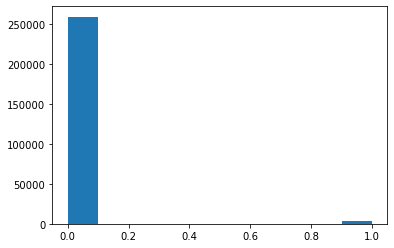

In [67]:
plt.hist(trainy[0].flatten())

(1640, 1, 512, 512) (1640, 1, 512, 512)


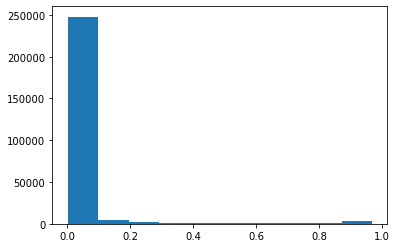

In [30]:
plt.hist(trainy[index].flatten())
print(trainy.shape, trainx.shape)

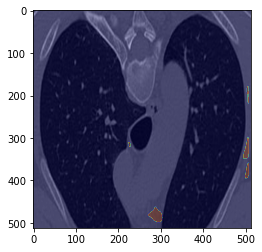

In [74]:
index = random.randint(0, 10)#1000, trainx.shape[0]-1)
index  = 0
#print(index, trainx.shape)
plt.imshow(trainx[index, 0].astype('float32'), cmap='gray')
plt.imshow(trainy[index, 0].astype('float32'), cmap='jet', alpha=0.3)

In [ ]:
# [STAR] For training the Group Norm using un-labelled data


import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp
from scipy.stats import entropy


basepath         = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/'
basepath_models  = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/models/single_models/'


def read_training_data(read_ids):
    x_array = []
    y_array = []
    
    for p in read_ids:
        name = basepath+'masks/'
        name = name+'study_'+p+'_mask.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(name))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(name.replace('_mask.nii.gz', '.nii.gz').replace('masks', 'studies/CT-1')))
        
        for t in range(mask.shape[0]):
            temp  = np.count_nonzero(mask[t].flatten())
            if temp > 0:
                x_array.append(np.expand_dims(vol[t], axis=0))
                y_array.append(np.expand_dims(mask[t], axis=0))

    x_array = (np.array(x_array)+1024.0)/1024.0
    y_array = np.array(y_array)
    
    return x_array, y_array

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def read_training_data_unlabelled(read_ids):
    x_array          = []
    x_array_lungmask = []
    
    names   = [x.split('_')[0] for x in read_ids]
    types   = [x.split('_')[1] for x in read_ids]
    count   = 0
    
    for p in names:
        name     = basepath+'studies/'+types[count]+'/'
        maskname = name+'study_'+p+'_mask.nii.gz'
        volname  = name+'study_'+p+'.nii.gz'
        
        mask = sitk.GetArrayFromImage(sitk.ReadImage(maskname))
        vol  = sitk.GetArrayFromImage(sitk.ReadImage(volname))
        mask[mask > 0] = 1
        
        for t in range(mask.shape[0]):
            if True:#t % 1 == 0:
                temp  = np.count_nonzero(mask[t].flatten())
                if temp > 0: # Check if lung region is present
                    x_array.append(np.expand_dims(vol[t], axis=0))
                    x_array_lungmask.append(np.expand_dims(mask[t], axis=0))
        
        count = count+1

    x_array          = (np.array(x_array)+1024.0)/1024.0
    x_array_lungmask = np.array(x_array_lungmask)
    
    return x_array, x_array_lungmask

def get_prediction(model, valx):
    output_array   = []
    batch_size     = 1
    
    model.eval()
    
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = torch.sigmoid(output)
        output = output.data.cpu().numpy()
        
        for k in range(output.shape[0]):
            output_array.append(output[k, 0])
    
    output_array = np.array(output_array).astype('float16')
    output_array = np.expand_dims(output_array, 1)
    
    return output_array

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)

        output = torch.sigmoid(output)        
        output = output.data.cpu().numpy()

        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        for pk in range(output.shape[0]):
            dt = dice(y[pk, 0, :, :], output[pk, 0, :, :])
            val_dice.append(dt)
    return val_dice

def train_model(model, optimizer, criterion, trainx, trainy):
    batch_size = 2
    loss_array = []
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)        
        loss   = criterion(output , y)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

def sort_data(trainx1, trainy1):
    # Sort the data
    X = trainx1
    Y = trainy1
    r = [t for t in sorted(zip(Y,X), key=lambda pair: np.sum(pair[0].flatten()))]
    
    trainx = []
    trainy = []
    
    for i in range(len(X)):
        trainy.append(r[i][0])
        trainx.append(r[i][1])
    
    trainx = np.array(trainx)
    trainy = np.array(trainy)
    
    return trainx, trainy
        
train_ids      = np.load(basepath+'TRAIN.npy')
val_ids        = np.load(basepath+'VALIDATION.npy')
test_ids       = np.load(basepath+'TEST.npy')
unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')

train_ids           = train_ids

trainx_l, trainy_l = read_training_data(train_ids)
valx, valy         = read_training_data(val_ids)
testx, testy       = read_training_data(test_ids)

print(trainx_l.shape, valx.shape, testx.shape)

valx_img = sitk.GetImageFromArray(valx.astype('float32')[:, 0, :, :])
sitk.WriteImage(valx_img, basepath+'CT-img.nii.gz')


model_teacher = SUNet(1,1)#UNetDoubleSmall(1,1)
model_teacher.cuda()


p1         = torch.load(basepath_models+"tmi-f-3-93.pt")
model_teacher.load_state_dict(p1)


device             = torch.device("cuda:0")
optimizer_student  = optim.Adam(model_student.parameters(), lr=0.0005)
criterion          = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())

val_loss_array   = []
train_loss_array = []

prev_max_teacher = -1000
prev_max    = -1000
model_count = 0
step_size   = 20
beta        = 0.9

val_dice_t   = evaluate_result(model_teacher, valx, valy)
print("Dice in the beginning ", np.mean(val_dice_t))

val_dice_t = np.mean(val_dice_t)
prev_max   = val_dice_t

teacher_dice_array = []

train_dice_array = []
val_dice_array   = []
test_dice_array  = []

model_save_name = "tmi-f-semi-sunet"

first_time = True

for epoch in range(300):
    temp_index                 = epoch%(int(len(unlabelled_ids)/step_size))
    trainx1, trainx1_lungmask  = read_training_data_unlabelled(unlabelled_ids[temp_index*step_size:temp_index*step_size+step_size])
    trainy1                    = get_prediction(model_teacher, trainx1)
    
    trainx, trainy = sort_data(trainx1, trainy1)
    if epoch%10 == 0:
        print(epoch, trainx.shape, trainy.shape)
    
    train_loss = train_model(model_student, optimizer_student, criterion, trainx, trainy)
    
    train_dice = evaluate_result(model_student, trainx_l, trainy_l)
    val_dice   = evaluate_result(model_student, valx, valy)
    
    # Update teacher weights
    if np.mean(val_dice) > val_dice_t:
        print(epoch, ' Updating Teacher Weights')
        torch.save(model_student.state_dict(), "temp.pt")
        torch.save(model_student.state_dict(), basepath_models+model_save_name+".pt")
        p1         = torch.load('temp.pt')
        
        model_teacher.load_state_dict(p1)
        val_dice_t = np.mean(val_dice)
    
    train_dice_array.append(np.mean(train_dice))
    val_dice_array.append(np.mean(val_dice))
    
    print("Step %d  Train Dice %.5f  Val Dice %.5f " % (epoch, np.mean(train_dice), np.mean(val_dice)))


In [ ]:
# [STAR] For selecting the most reliable weights

s  = 300
a1 = np.zeros([s, 236])
b1 = np.zeros([s, 126])

count = 0

x = []
y = []
z = []

model_save_name = 'tmi-f-single-semi'

def scoring_function(val_array, test_array, epoch):
    score_array = []
    step_size   = 5
    alpha       = 10
    
    temp_array     = val_array[epoch-step_size:epoch]
    sum_array      = 1-np.mean(temp_array, axis=0)
    var_array      = np.std(temp_array, axis=0)

    score_temp     = sum_array + alpha*var_array
    final_score    = score_temp*val_array[epoch]
    
    return final_score

for epoch in range(s):
    a = np.load('/home/yu-hao/AttentionDeepMIL/val_dice_array-'+model_save_name+'--'+str(epoch)+'.npy')
    a1[epoch] = a

score_array = []
for epoch in range(100, 300):
    final_score = scoring_function(a1, b1, epoch)
    score_array.append(np.mean(final_score))

index = np.argmax(score_array) 
print('Most reliable Weights Index ', index, score_array[index])


In [ ]:
# For creating the dataset for COVID-19

import imageio
import cv2

arr_x = []
arr_y = []

#train = glob.glob('/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/TestingSet/LungInfection-Test/Imgs/*.jpg')
train = glob.glob('/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/UnlabelledSet/Imgs/*.jpg')

for t in train:
    img = imageio.imread(t)
    res = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    arr_x.append(res.T)
    
    #img = imageio.imread(t.replace('Imgs', 'GT').replace('jpg', 'png'))
    #res = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
    #arr_y.append(res.T)
    
    #print(img.shape, res.shape, t.split('/')[-1])


arr_x = np.array(arr_x)
arr_y = np.array(arr_y)

print(arr_x.shape, arr_y.shape)

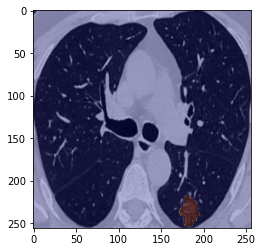

In [41]:
#np.save('/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/unlabelled_x.npy', arr_x)
#np.save('/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/test_y.npy', arr_y)


basepath         = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/'
basepath_models  = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/COVID19/COVID-SemiSeg/Dataset/models/'


trainx_l = np.load(basepath+'train_x.npy')
trainy_l = np.load(basepath+'train_y.npy')

valx = trainx_l[40:]
valy = trainy_l[40:]

trainx_l = trainx_l[:40]
trainy_l = trainy_l[:40]

testx = np.load(basepath+'test_x.npy')
testy = np.load(basepath+'test_y.npy')

index = random.randint(0, trainx_l.shape[0]-1)
plt.imshow(trainx_l[index], cmap='gray')
plt.imshow(trainy_l[index], cmap='jet', alpha=0.3)